# High In-Degree Neurons Analysis

This notebook identifies neurons with high in-degree from the Hemibrain dataset and creates visualizations to determine appropriate thresholds.

Code adapted from:
- `oviIN_specs_rankings.ipynb`: Fetching traced neurons
- `mesoscale_connectivity.ipynb`: Understanding neuron connectivity

## Setup and Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
!pip install neuprint-python

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 7.7 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5031 sha256=cee50806cc04b1a76ada07e16e7e00b2d59fa10c3cd656c5c6361f32ebaff861
  Stored in directory: /root/.cache/pip/wheels/a5/d7/98/f56ae733748cd0fa577172bda0e73e0b1f1793c98e09b9e458
Successfully built asciitree


In [3]:
# Imports - adapted from oviIN_specs_rankings.ipynb (lines 34-62)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neuprint import Client, fetch_neurons, NeuronCriteria as NC
import warnings

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Matplotlib settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
%matplotlib inline

print("Imports complete")

Imports complete


## Connect to Neuprint
Adapted from `oviIN_specs_rankings.ipynb` (lines 17-26)

In [4]:
# Read authentication token
from google.colab import userdata
auth_token = userdata.get('NEUPRINT_TOKEN')

# Connect to Neuprint
np_client = Client(
    'neuprint.janelia.org',
    dataset='hemibrain:v1.2.1',
    token=auth_token
)
version = np_client.fetch_version()

print(f"Connected to neuprint.janelia.org")
print(f"  Dataset: hemibrain:v1.2.1")
print(f"  Version: {version}")

Connected to neuprint.janelia.org
  Dataset: hemibrain:v1.2.1
  Version: 1.7.10


## Fetch All Traced Neurons
Adapted from `oviIN_specs_rankings.ipynb` (lines 222-300)

Fetch neurons with:
- `status='Traced'`: Fully reconstructed neurons
- `cropped=False`: Not cut off at volume boundaries

The `upstream` field = in-degree (number of presynaptic partners)

In [5]:
# Define criteria for traced, non-cropped neurons
criteria = NC(status='Traced', cropped=False)

print("Fetching neurons")
neurons_df, roi_counts = fetch_neurons(criteria, client=np_client)

print(f"\nFetched {len(neurons_df):,} traced neurons")
print(f"\nColumns: {list(neurons_df.columns[:10])}...")
print(f"\nFirst 5 neurons:")
neurons_df[['bodyId', 'instance', 'type', 'pre', 'post', 'upstream']].head()

Fetching neurons

Fetched 21,739 traced neurons

Columns: ['bodyId', 'instance', 'type', 'pre', 'post', 'downstream', 'upstream', 'mito', 'size', 'status']...

First 5 neurons:


bodyId             instance    type  pre  post  upstream
0  200326126              CL141_L   CL141  395  1068      1068
1  202916528      FS4C(FQ12)_C4_R    FS4C   95   431       431
2  203253072  FS4A(AB)(FQ12)_C3_R    FS4A   62   366       366
3  203253253      SMP505(PDM22)_L  SMP505  415  3112      3112
4  203257652      FS4C(FQ12)_C6_R    FS4C   65   270       270

## Calculate In-Degree Statistics

In [6]:
# Extract in-degree values (upstream = number of presynaptic partners)
indegree_values = neurons_df['upstream'].values

# Calculate statistics
stats = {
    'n_neurons': len(neurons_df),
    'mean': np.mean(indegree_values),
    'median': np.median(indegree_values),
    'std': np.std(indegree_values),
    'min': np.min(indegree_values),
    'max': np.max(indegree_values),
    'q25': np.percentile(indegree_values, 25),
    'q75': np.percentile(indegree_values, 75),
    'q90': np.percentile(indegree_values, 90),
    'q95': np.percentile(indegree_values, 95),
    'q99': np.percentile(indegree_values, 99)
}

# Print statistics
print(f"Total neurons: {stats['n_neurons']:,}")
print(f"\nIn-degree statistics:")
print(f"  Mean:     {stats['mean']:.1f}")
print(f"  Median:   {stats['median']:.1f}")
print(f"  Std Dev:  {stats['std']:.1f}")
print(f"  Min:      {stats['min']:.0f}")
print(f"  Max:      {stats['max']:.0f}")
print(f"\nKey percentiles:")
print(f"  75th:     {stats['q75']:.0f}")
print(f"  90th:     {stats['q90']:.0f}")
print(f"  95th:     {stats['q95']:.0f}")
print(f"  99th:     {stats['q99']:.0f}")

Total neurons: 21,739

In-degree statistics:
  Mean:     871.6
  Median:   494.0
  Std Dev:  1818.0
  Min:      2
  Max:      127151

Key percentiles:
  75th:     856
  90th:     1766
  95th:     2838
  99th:     6926


## Visualize Distribution

Four complementary views:
1. **Linear histogram**: Overall shape
2. **Log histogram**: Better view of full range
3. **CDF**: Cumulative distribution (easy to read percentiles)
4. **Box plot**: Compact summary

<Figure size 1600x1200 with 0 Axes>

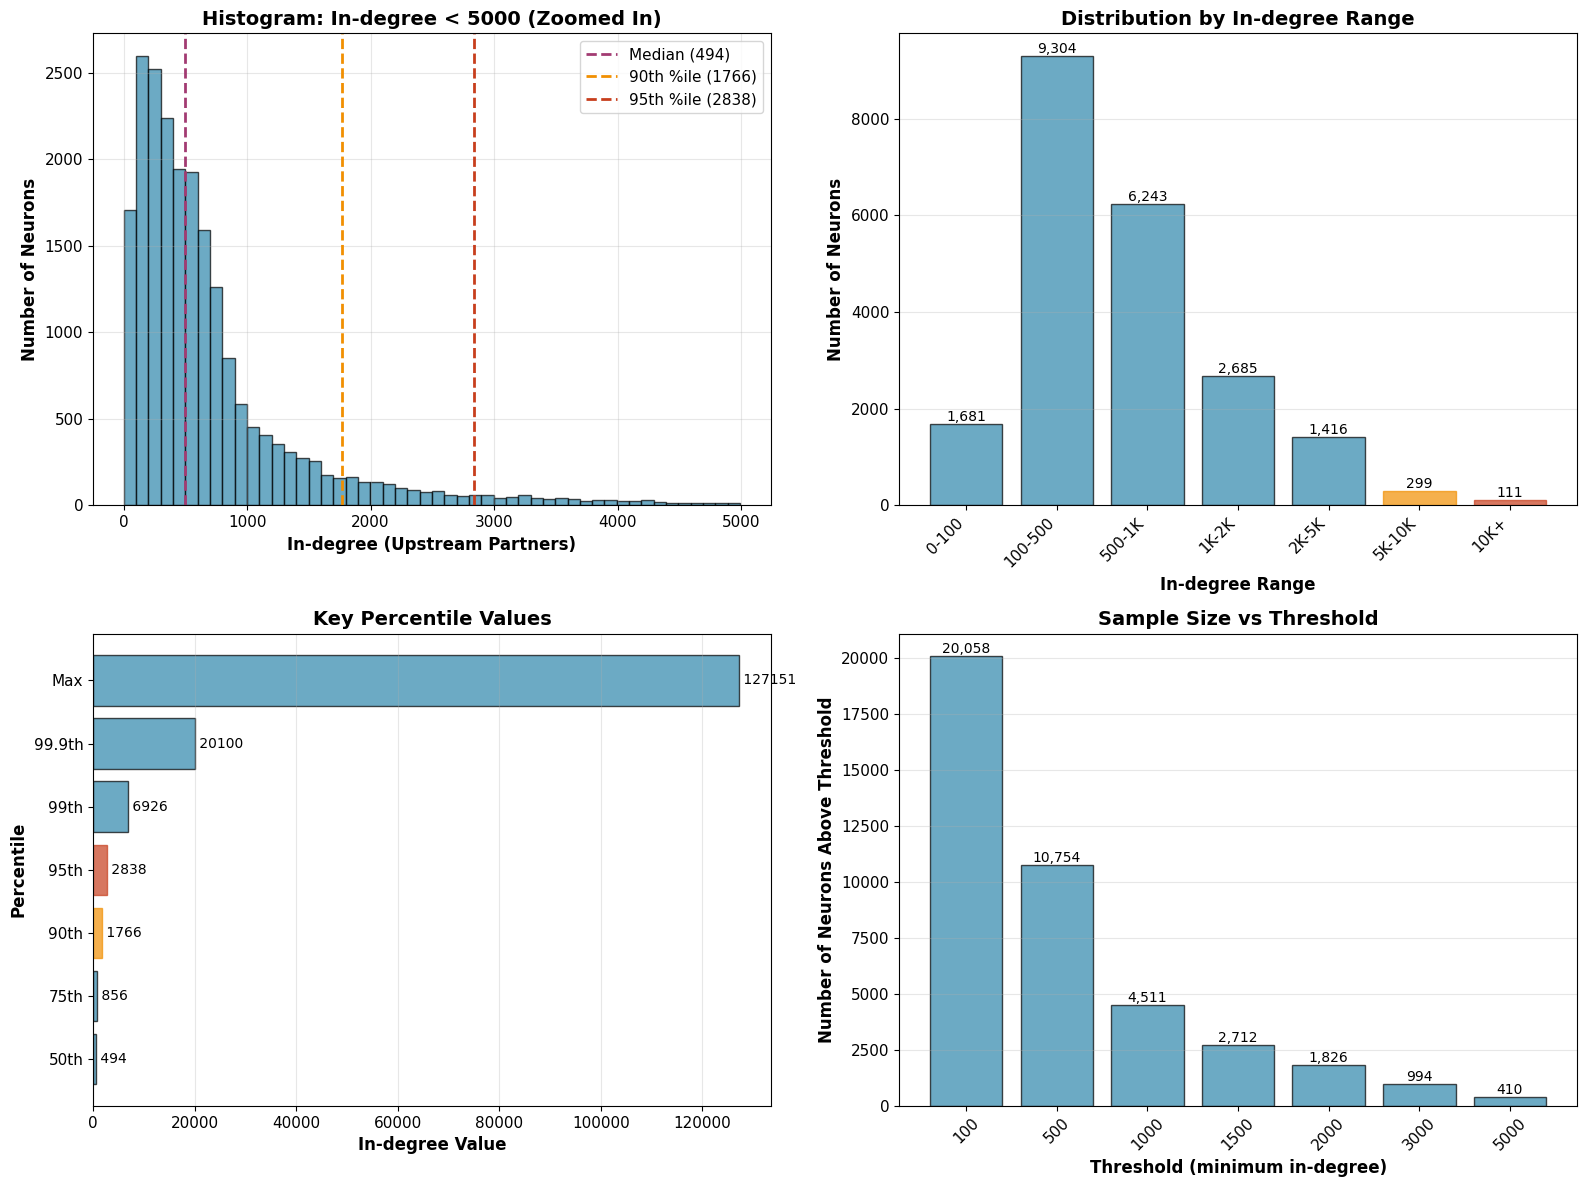

In [7]:
# Create 4-panel figure
fig = plt.figure(figsize=(16, 12))

# Colors for consistency
colors = {
    'primary': '#2E86AB',
    'median': '#A23B72',
    'q90': '#F18F01',
    'q95': '#C73E1D'
}

# Create interpretable histogram
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Histogram with reasonable bins (focus on the bulk of data)
ax1 = axes[0, 0]
# Focus on neurons with in-degree < 5000 to see the structure better
mask = indegree_values < 5000
ax1.hist(indegree_values[mask], bins=50, color=colors['primary'], alpha=0.7, edgecolor='black')
ax1.axvline(stats['median'], color=colors['median'], linestyle='--', linewidth=2, label=f"Median ({stats['median']:.0f})")
ax1.axvline(stats['q90'], color=colors['q90'], linestyle='--', linewidth=2, label=f"90th %ile ({stats['q90']:.0f})")
ax1.axvline(stats['q95'], color=colors['q95'], linestyle='--', linewidth=2, label=f"95th %ile ({stats['q95']:.0f})")
ax1.set_xlabel('In-degree (Upstream Partners)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Neurons', fontsize=12, fontweight='bold')
ax1.set_title('Histogram: In-degree < 5000 (Zoomed In)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Histogram by ranges (categorical)
ax2 = axes[0, 1]
bins_edges = [0, 100, 500, 1000, 2000, 5000, 10000, np.inf]
bins_labels = ['0-100', '100-500', '500-1K', '1K-2K', '2K-5K', '5K-10K', '10K+']
counts, _ = np.histogram(indegree_values, bins=bins_edges)
bars = ax2.bar(bins_labels, counts, color=colors['primary'], alpha=0.7, edgecolor='black')
# Highlight the high in-degree ranges
bars[-1].set_color(colors['q95'])
bars[-2].set_color(colors['q90'])
ax2.set_xlabel('In-degree Range', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Neurons', fontsize=12, fontweight='bold')
ax2.set_title('Distribution by In-degree Range', fontsize=14, fontweight='bold')
ax2.tick_labels = ax2.set_xticklabels(bins_labels, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
# Add counts on top of bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}',
             ha='center', va='bottom', fontsize=10)

# Panel 3: Percentile breakdown
ax3 = axes[1, 0]
percentiles = [50, 75, 90, 95, 99, 99.9, 100]
percentile_values = [np.percentile(indegree_values, p) for p in percentiles]
percentile_labels = ['50th', '75th', '90th', '95th', '99th', '99.9th', 'Max']
bars = ax3.barh(percentile_labels, percentile_values, color=colors['primary'], alpha=0.7, edgecolor='black')
bars[2].set_color(colors['q90'])  # Highlight 90th
bars[3].set_color(colors['q95'])  # Highlight 95th
ax3.set_xlabel('In-degree Value', fontsize=12, fontweight='bold')
ax3.set_ylabel('Percentile', fontsize=12, fontweight='bold')
ax3.set_title('Key Percentile Values', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
# Add values at end of bars
for bar, val in zip(bars, percentile_values):
    ax3.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {val:.0f}',
             va='center', fontsize=10)

# Panel 4: Sample sizes at different thresholds
ax4 = axes[1, 1]
thresholds_viz = [100, 500, 1000, 1500, 2000, 3000, 5000]
sample_sizes = [np.sum(indegree_values >= t) for t in thresholds_viz]
bars = ax4.bar([str(t) for t in thresholds_viz], sample_sizes, color=colors['primary'], alpha=0.7, edgecolor='black')
ax4.set_xlabel('Threshold (minimum in-degree)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Neurons Above Threshold', fontsize=12, fontweight='bold')
ax4.set_title('Sample Size vs Threshold', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')
# Add counts on bars
for bar, count in zip(bars, sample_sizes):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Interpretation of Results

The in-degree distribution of Hemibrain traced neurons (n=21,739) is highly right-skewed, with a median of 494 and mean of 872 upstream partners. The majority of neurons (78%) have fewer than 1,000 presynaptic partners, while a small subset exhibits hub-like connectivity. The distribution shows a clear separation around 2,000 upstream partners, above which only 8% of neurons remain. For subsequent modularity maximization analysis, recommend using the **95th percentile (2,838 upstream partners) as the threshold for "high in-degree" neurons**, which yields approximately 1,087 neurons. This threshold is statistically rigorous, computationally manageable, and captures neurons with connectivity patterns distinctly different from the bulk population. The distribution also reveals a small number of extreme hubs (n=111 with >10,000 partners, including one neuron with 127,151 partners), which may warrant separate investigation as potential major integrative centers in the fly brain connectome.

## Threshold Comparison

Compare different threshold options to decide how many neurons to include

## High In-Degree Neurons at Different Thresholds

Display neurons above selected thresholds as tables

In [8]:
# Define thresholds to examine in detail
# Based on analysis: focusing on 95th percentile and comparing with stricter thresholds
test_thresholds = [int(stats['q95']), 3000, 5000]  # 95th percentile, 3K, and 5K

for threshold in test_thresholds:
    # Filter neurons
    high_indegree = neurons_df[neurons_df['upstream'] >= threshold].copy()
    high_indegree = high_indegree.sort_values('upstream', ascending=False)

    # Select columns
    display_df = high_indegree[['bodyId', 'instance', 'type', 'upstream', 'post', 'pre']].copy()
    display_df.columns = ['bodyId', 'instance', 'type', 'in-degree', 'n_post', 'n_pre']

    # Print summary
    print(f"HIGH IN-DEGREE NEURONS (threshold ≥ {threshold})")
    print(f"Total: {len(display_df):,} neurons ({100*len(display_df)/len(neurons_df):.2f}% of all)")
    print(f"\nTop 20 neurons:")
    print()

    # Display table
    display(display_df.head(20))
    print("\n")

HIGH IN-DEGREE NEURONS (threshold ≥ 2838)
Total: 1,088 neurons (5.00% of all)

Top 20 neurons:



bodyId                  instance     type  in-degree  n_post  n_pre
1882    425790257                     APL_R      APL     127151  127151  16190
21411  5813105172                     DPM_R      DPM      77269   77269  17628
4009    612371421          MBON01(y5B'2a)_R   MBON01      32544   32544   2208
1874    425276848                     DPM_L      DPM      30007   30007   7088
4700    673509195          MBON01(y5B'2a)_L   MBON01      29244   29244   2205
19985  5813039148                 PVLP011_R  PVLP011      28662   28662   4693
1854    424767514      MBON11(y1pedc>a/B)_R   MBON11      27642   27642   1646
14913  1640909284           lLN2F_b(Full)_R  lLN2F_b      27355   27355   7998
6203    799586652  MBON05(y4>y1y2)(AVM07)_L   MBON05      27110   27110   1565
19671  5813024698           lLN2F_b(Full)_R  lLN2F_b      26039   26039   8152
393     298258513                  SMP108_R   SMP108      23289   23289   2753
9422   1078693835           MBON09(y3B'1)_R   MBON09      23111   23111   1297
1805    423101189                   oviIN_R    oviIN      23029   23029   6863
20319  5813050499                 AVLP082_R  AVLP082      22759   22759   4957
7957    947573616                 AVLP016_R  AVLP016      21382   21382   4740
2858    518930199              MBON35(y2)_R   MBON35      21335   21335   1746
1792    422725634     MBON06(B1>a)(AVM07)_L   MBON06      21000   21000   1356
17520  2124762952                   mALC2_L    mALC2      20985   20985   7281
21693  5901218894           lLN2F_a(Full)_R  lLN2F_a      20616   20616   5875
8755   1016835041    MBON09(y3B'1)(AVM17)_L   MBON09      20281   20281   1291



HIGH IN-DEGREE NEURONS (threshold ≥ 3000)
Total: 994 neurons (4.57% of all)

Top 20 neurons:



bodyId                  instance     type  in-degree  n_post  n_pre
1882    425790257                     APL_R      APL     127151  127151  16190
21411  5813105172                     DPM_R      DPM      77269   77269  17628
4009    612371421          MBON01(y5B'2a)_R   MBON01      32544   32544   2208
1874    425276848                     DPM_L      DPM      30007   30007   7088
4700    673509195          MBON01(y5B'2a)_L   MBON01      29244   29244   2205
19985  5813039148                 PVLP011_R  PVLP011      28662   28662   4693
1854    424767514      MBON11(y1pedc>a/B)_R   MBON11      27642   27642   1646
14913  1640909284           lLN2F_b(Full)_R  lLN2F_b      27355   27355   7998
6203    799586652  MBON05(y4>y1y2)(AVM07)_L   MBON05      27110   27110   1565
19671  5813024698           lLN2F_b(Full)_R  lLN2F_b      26039   26039   8152
393     298258513                  SMP108_R   SMP108      23289   23289   2753
9422   1078693835           MBON09(y3B'1)_R   MBON09      23111   23111   1297
1805    423101189                   oviIN_R    oviIN      23029   23029   6863
20319  5813050499                 AVLP082_R  AVLP082      22759   22759   4957
7957    947573616                 AVLP016_R  AVLP016      21382   21382   4740
2858    518930199              MBON35(y2)_R   MBON35      21335   21335   1746
1792    422725634     MBON06(B1>a)(AVM07)_L   MBON06      21000   21000   1356
17520  2124762952                   mALC2_L    mALC2      20985   20985   7281
21693  5901218894           lLN2F_a(Full)_R  lLN2F_a      20616   20616   5875
8755   1016835041    MBON09(y3B'1)(AVM17)_L   MBON09      20281   20281   1291



HIGH IN-DEGREE NEURONS (threshold ≥ 5000)
Total: 410 neurons (1.89% of all)

Top 20 neurons:



bodyId                  instance     type  in-degree  n_post  n_pre
1882    425790257                     APL_R      APL     127151  127151  16190
21411  5813105172                     DPM_R      DPM      77269   77269  17628
4009    612371421          MBON01(y5B'2a)_R   MBON01      32544   32544   2208
1874    425276848                     DPM_L      DPM      30007   30007   7088
4700    673509195          MBON01(y5B'2a)_L   MBON01      29244   29244   2205
19985  5813039148                 PVLP011_R  PVLP011      28662   28662   4693
1854    424767514      MBON11(y1pedc>a/B)_R   MBON11      27642   27642   1646
14913  1640909284           lLN2F_b(Full)_R  lLN2F_b      27355   27355   7998
6203    799586652  MBON05(y4>y1y2)(AVM07)_L   MBON05      27110   27110   1565
19671  5813024698           lLN2F_b(Full)_R  lLN2F_b      26039   26039   8152
393     298258513                  SMP108_R   SMP108      23289   23289   2753
9422   1078693835           MBON09(y3B'1)_R   MBON09      23111   23111   1297
1805    423101189                   oviIN_R    oviIN      23029   23029   6863
20319  5813050499                 AVLP082_R  AVLP082      22759   22759   4957
7957    947573616                 AVLP016_R  AVLP016      21382   21382   4740
2858    518930199              MBON35(y2)_R   MBON35      21335   21335   1746
1792    422725634     MBON06(B1>a)(AVM07)_L   MBON06      21000   21000   1356
17520  2124762952                   mALC2_L    mALC2      20985   20985   7281
21693  5901218894           lLN2F_a(Full)_R  lLN2F_a      20616   20616   5875
8755   1016835041    MBON09(y3B'1)(AVM17)_L   MBON09      20281   20281   1291

## Recommendations

Based on the analysis above, here are suggested thresholds for different use cases

## Select Your Threshold and Extract Neurons

After reviewing the plots and tables above, set your threshold here to get the final list of neurons

## Threshold Recommendations and Key Observations

### Threshold Options

**1. Conservative (top 10%): 1,766 upstream partners**
- Includes 2,174 neurons
- Use for: Large sample size, exploratory analysis
- Note: May include many "moderately connected" neurons

**2. Moderate (top 5%): 2,838 upstream partners**
- Includes 1,088 neurons
- Use for: Balanced sample, typical hub analysis
- Captures all major known integrative centers (MBONs, DPM, APL)
- **oviIN_R included at rank #13 with 23,029 upstream partners**

**3. Strict (top 1%): 6,926 upstream partners**
- Includes 217 neurons
- Use for: Most connected hubs, focused analysis
- Very selective, may limit statistical power

### Key Observations from High In-Degree Neurons

**Top Hub:** APL_R (127,151 upstream partners) - Giant GABAergic neuron providing global inhibition to mushroom body

**Dominant Neuron Types in Top 20:**
- MBONs (Mushroom Body Output Neurons): 7 neurons - integrate olfactory learning
- DPM (Dorsal Paired Medial): 2 neurons - modulatory feedback
- lLN2F (lateral Local Neurons): 3 neurons - local processing
- AVLP/PVLP neurons: 3 neurons - lateral protocerebrum integration

**Our neuron of interest (oviIN_R):** Rank #13 with 23,029 upstream partners - clearly a major integrative hub in the egg-laying circuit

### Selection Criteria to Consider
- Sample size for statistical power (modularity maximization)
- Computational resources (runtime scales with network size)
- Biological relevance (capture known integrative centers)
- Clear separation from bulk population (natural break ~2,000)

**Suggestion: Use 95th percentile (≥2,838) for subsequent modularity analysis**

In [9]:
# SET YOUR THRESHOLD HERE
selected_threshold = int(stats['q95'])  # 95th percentile = 2,838 upstream partners

# Extract high in-degree neurons
high_indegree_neurons = neurons_df[neurons_df['upstream'] >= selected_threshold].copy()
high_indegree_neurons = high_indegree_neurons.sort_values('upstream', ascending=False)

# Get bodyIds for next steps
high_indegree_bodyids = high_indegree_neurons['bodyId'].tolist()

print("SELECTED THRESHOLD FOR ANALYSIS")
print(f"\nThreshold: {selected_threshold} upstream partners (95th percentile)")
print(f"Number of high in-degree neurons: {len(high_indegree_bodyids):,} ({100*len(high_indegree_bodyids)/len(neurons_df):.2f}% of all neurons)")
print(f"\nVariable created: high_indegree_bodyids (list of {len(high_indegree_bodyids):,} bodyIds)")
print(f"Variable created: high_indegree_neurons (DataFrame with full neuron data)")
print(f"\nReady for Step 2: Modularity maximization on input subconnectomes")
print(f"\nTop 10 hub neurons (by bodyId):")
print(high_indegree_bodyids[:10])
print(f"\nIncludes oviIN_R: {423101189 in high_indegree_bodyids}")

SELECTED THRESHOLD FOR ANALYSIS

Threshold: 2838 upstream partners (95th percentile)
Number of high in-degree neurons: 1,088 (5.00% of all neurons)

Variable created: high_indegree_bodyids (list of 1,088 bodyIds)
Variable created: high_indegree_neurons (DataFrame with full neuron data)

Ready for Step 2: Modularity maximization on input subconnectomes

Top 10 hub neurons (by bodyId):
[425790257, 5813105172, 612371421, 425276848, 673509195, 5813039148, 424767514, 1640909284, 799586652, 5813024698]

Includes oviIN_R: True


---

## Next Steps

Now that we have `high_indegree_bodyids`, proceed to Step 2:

1. **For each bodyId**, extract input subconnectome using code from `mesoscale_connectivity.ipynb`
2. **Run modularity maximization** using `gcm_script.py`
3. **Analyze spatial clustering** using code from `spatial_synapse_clustering.ipynb`

The variable `high_indegree_neurons` contains the full DataFrame with all properties if needed.

## Step 2

### Step 2.1

We now proceed to extract the input subconnectomes for 15 high in-degree neurons

In [10]:
import os
from neuprint import fetch_simple_connections, fetch_synapse_connections, fetch_adjacencies, fetch_neurons, NeuronCriteria as NC, SynapseCriteria as SC
import pandas as pd
import numpy as np
import subprocess

In [11]:
# Band sampling utility functions

def get_percentile_band_indices(total_neurons, start_pct, end_pct):
    """Get array indices for a percentile band from a SORTED list (high to low)."""
    start_idx = int(total_neurons * start_pct / 100)
    end_idx = int(total_neurons * end_pct / 100)
    return start_idx, end_idx


def sample_from_band(bodyid_list, start_pct, end_pct, n_samples, random_state=42):
    """Sample neurons from a percentile band."""
    np.random.seed(random_state)

    total_neurons = len(bodyid_list)
    start_idx, end_idx = get_percentile_band_indices(total_neurons, start_pct, end_pct)

    band_neurons = bodyid_list[start_idx:end_idx]
    band_size = len(band_neurons)

    if n_samples >= band_size:
        print(f"Warning: Requested {n_samples} samples but band {start_pct}-{end_pct}% only has {band_size} neurons.")
        print(f"Returning all {band_size} neurons from this band.")
        return band_neurons

    sampled_indices = np.random.choice(band_size, size=n_samples, replace=False)
    sampled_bodyids = [band_neurons[i] for i in sorted(sampled_indices)]

    return sampled_bodyids


def visualize_band_sampling(bodyid_list, neurons_df, bands_config, title="Band Sampling Visualization"):
    """Visualize the sampling strategy across percentile bands."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Get in-degree values
    indegree_values = []
    for bodyid in bodyid_list:
        indegree = neurons_df[neurons_df['bodyId'] == bodyid]['upstream'].values[0]
        indegree_values.append(indegree)

    # Panel 1: Distribution with band highlights
    ax1 = axes[0, 0]
    ax1.plot(range(len(indegree_values)), indegree_values, alpha=0.6, color='gray', linewidth=1)

    for band in bands_config:
        start_idx, end_idx = get_percentile_band_indices(len(bodyid_list), band['start_pct'], band['end_pct'])
        ax1.axvspan(start_idx, end_idx, alpha=0.2, color=band['color'], label=band['label'])

    ax1.set_xlabel('Neuron Rank (High to Low In-Degree)', fontsize=12)
    ax1.set_ylabel('In-Degree (Upstream Partners)', fontsize=12)
    ax1.set_title('In-Degree Distribution with Band Regions', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Panel 2: Sampled neurons positions
    ax2 = axes[0, 1]
    ax2.plot(range(len(indegree_values)), indegree_values, alpha=0.3, color='gray', linewidth=1)

    for band in bands_config:
        sampled_indices = [bodyid_list.index(bid) for bid in band['sampled_bodyids']]
        sampled_indegrees = [indegree_values[i] for i in sampled_indices]
        ax2.scatter(sampled_indices, sampled_indegrees, s=100, alpha=0.7,
                   color=band['color'], label=f"{band['label']} (n={len(band['sampled_bodyids'])})",
                   edgecolors='black', linewidth=1)

    ax2.set_xlabel('Neuron Rank', fontsize=12)
    ax2.set_ylabel('In-Degree', fontsize=12)
    ax2.set_title('Sampled Neurons Positions', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Panel 3: Band size comparison
    ax3 = axes[1, 0]
    band_labels = [band['label'] for band in bands_config]
    band_sizes = [len(band['sampled_bodyids']) for band in bands_config]
    band_colors = [band['color'] for band in bands_config]

    bars = ax3.bar(band_labels, band_sizes, color=band_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax3.set_ylabel('Number of Sampled Neurons', fontsize=12)
    ax3.set_title('Sample Size per Band', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    for bar, size in zip(bars, band_sizes):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(size)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Panel 4: In-degree statistics per band
    ax4 = axes[1, 1]

    band_stats = []
    for band in bands_config:
        sampled_indegrees = [neurons_df[neurons_df['bodyId'] == bid]['upstream'].values[0]
                            for bid in band['sampled_bodyids']]
        band_stats.append(sampled_indegrees)

    bp = ax4.boxplot(band_stats, labels=band_labels, patch_artist=True, widths=0.6)

    for patch, color in zip(bp['boxes'], band_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax4.set_ylabel('In-Degree (Upstream Partners)', fontsize=12)
    ax4.set_title('In-Degree Distribution by Band', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')

    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


def get_band_summary(bodyid_list, neurons_df, bands_config):
    """Print summary statistics for each band."""
    print("\n" + "="*80)
    print("BAND SAMPLING SUMMARY")
    print("="*80)

    total_sampled = sum(len(band['sampled_bodyids']) for band in bands_config)
    print(f"\nTotal neurons sampled: {total_sampled}")
    print(f"Total neurons available: {len(bodyid_list)}")
    print(f"Sampling rate: {100*total_sampled/len(bodyid_list):.2f}%\n")

    for band in bands_config:
        print(f"\n{band['label']} ({band['start_pct']}-{band['end_pct']}%):")
        print("-" * 60)

        start_idx, end_idx = get_percentile_band_indices(len(bodyid_list), band['start_pct'], band['end_pct'])
        band_total = end_idx - start_idx
        n_sampled = len(band['sampled_bodyids'])

        print(f"  Total neurons in band: {band_total}")
        print(f"  Neurons sampled: {n_sampled}")
        print(f"  Sampling rate: {100*n_sampled/band_total:.1f}%")

        sampled_indegrees = [neurons_df[neurons_df['bodyId'] == bid]['upstream'].values[0]
                            for bid in band['sampled_bodyids']]

        print(f"  In-degree range: {min(sampled_indegrees):,} - {max(sampled_indegrees):,}")
        print(f"  Mean in-degree: {np.mean(sampled_indegrees):,.0f}")
        print(f"  Median in-degree: {np.median(sampled_indegrees):,.0f}")

    print("\n" + "="*80)


# Configure bands for 50-neuron sampling
BANDS = [
    {
        'start_pct': 0,
        'end_pct': 10,
        'n_samples': 50,
        'label': 'Band 1 (0-10%)',
        'color': '#E63946'
    },
    {
        'start_pct': 10,
        'end_pct': 20,
        'n_samples': 50,
        'label': 'Band 2 (10-20%)',
        'color': '#F4A261'
    }
]

# Sample from each band
for band in BANDS:
    sampled = sample_from_band(
        bodyid_list=high_indegree_bodyids,
        start_pct=band['start_pct'],
        end_pct=band['end_pct'],
        n_samples=band['n_samples'],
        random_state=42
    )
    band['sampled_bodyids'] = sampled
    print(f"Sampled {len(sampled)} neurons from {band['label']}")

# Combine all sampled body IDs (This is what Pablo's code expects)
test_bodyids = []
for band in BANDS:
    test_bodyids.extend(band['sampled_bodyids'])

# Include oviIN_R if not already sampled
if 423101189 not in test_bodyids:
    test_bodyids.append(423101189)
    print(f"\nAdded oviIN_R (423101189) to sample")

print(f"\nTotal neurons for analysis: {len(test_bodyids)}")

Sampled 50 neurons from Band 1 (0-10%)
Sampled 50 neurons from Band 2 (10-20%)

Total neurons for analysis: 100


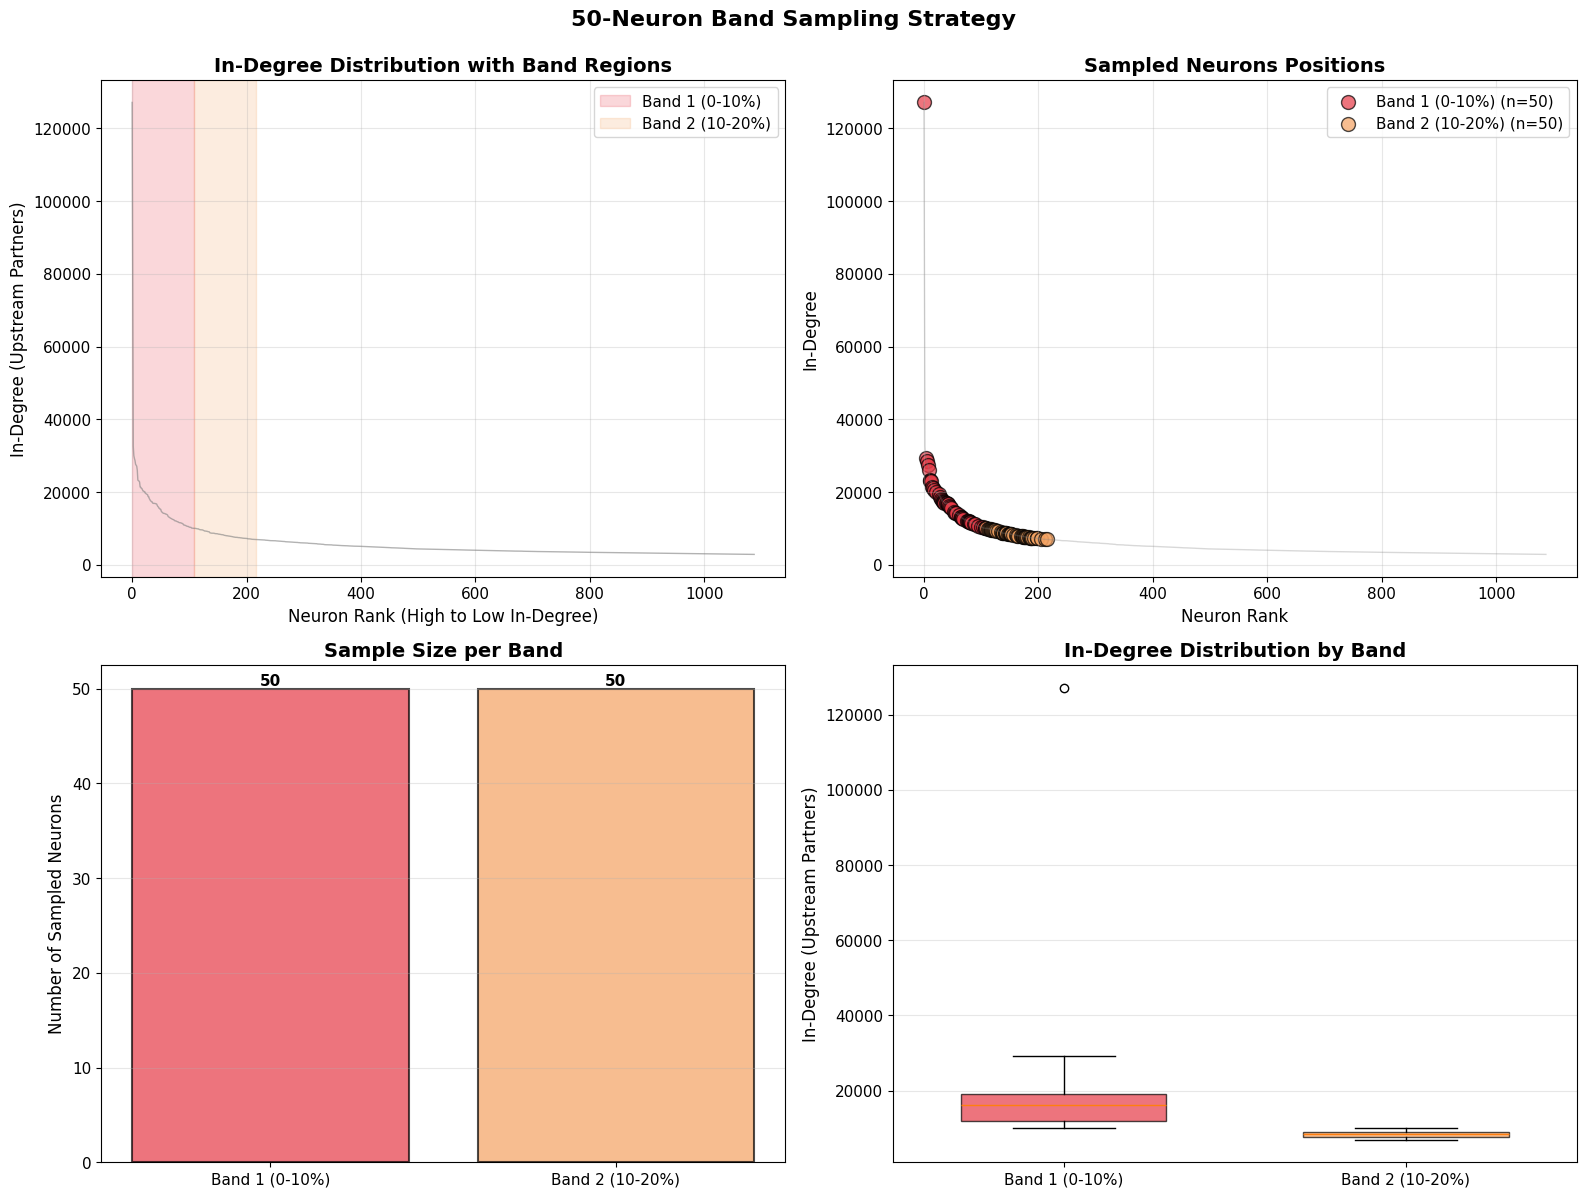

In [12]:
# Visualize band sampling strategy
visualize_band_sampling(
    bodyid_list=high_indegree_bodyids,
    neurons_df=high_indegree_neurons,
    bands_config=BANDS,
    title="50-Neuron Band Sampling Strategy"
)

In [13]:
# Print detailed band summary
get_band_summary(
    bodyid_list=high_indegree_bodyids,
    neurons_df=high_indegree_neurons,
    bands_config=BANDS
)


BAND SAMPLING SUMMARY

Total neurons sampled: 100
Total neurons available: 1088
Sampling rate: 9.19%


Band 1 (0-10%) (0-10%):
------------------------------------------------------------
  Total neurons in band: 108
  Neurons sampled: 50
  Sampling rate: 46.3%
  In-degree range: 10,018 - 127,151
  Mean in-degree: 18,531
  Median in-degree: 16,137

Band 2 (10-20%) (10-20%):
------------------------------------------------------------
  Total neurons in band: 109
  Neurons sampled: 50
  Sampling rate: 45.9%
  In-degree range: 6,949 - 10,012
  Mean in-degree: 8,370
  Median in-degree: 8,394



Code obtained from `https://github.com/Gutierrez-lab/oviIN-inputs/blob/main/get_connectome.py`

In [14]:
"""Get the personal connectome of neuron(s) that are inputed by the user. """

import pandas as pd

def get_connectome(main_neurons, exclude_main_neurons=False, connectome_scope='full', weight_threshold=1, connectome_by_type=False, only_traced=True, only_noncropped = True):
    """Get the personal connectome of neuron or neurons that are inputed by the user.
    This function returns a connectome dataframe that contains the weighted connections between bodyIds. The synaptic weights
    are collapsed across ROIs. This dataframe can be used to create a graph of the connectome in NetworkX using
    from_pandas_edgelist. However, the dataframe will need to be reformatted in order to run the clustering algorithms.

    main_neurons: can be a single bodyId, a list of bodyIds, or NeuronCriteria

    Options:
        - include the main neurons or not
        - input, output, or full connectome
        - weight threshold for the connection strengths to include in the connectome
        - connectome based on types rather than bodyIds
        - whether to only return Traced neurons
        - whether to only return uncropped neurons"""


    # these dfs return all the neurons involved in making the specified connections to the main neurons
    pre, pre_conns = fetch_adjacencies(None, main_neurons)
    post, post_conns = fetch_adjacencies(main_neurons, None)


    # if only_traced or only_noncropped is true, we need to fetch_neurons to fetch information about neurons
    if only_traced or only_noncropped:
        pre_neurons_df, roi_counts_df_ = fetch_neurons(pre['bodyId'])
        post_neurons_df, roi_counts_df_ = fetch_neurons(post['bodyId'])
        # if only_traced is True, remove neurons that are not traced.
        if only_traced:
            # merge status column into pre and post
            pre = pre.merge(pre_neurons_df[['bodyId','status']], on='bodyId', how='left')
            post = post.merge(post_neurons_df[['bodyId','status']], on='bodyId', how='left')

            # filter out untraced neurons
            pre = pre[pre['status'] == 'Traced']
            post = post[post['status'] == 'Traced']

        # if only_noncropped is True, remove neurons that are cropped
        if only_noncropped:
            pre = pre.merge(pre_neurons_df[['bodyId','cropped']], on='bodyId', how='left')
            post = post.merge(post_neurons_df[['bodyId','cropped']], on='bodyId', how='left')

            pre = pre[pre['cropped'] == False]
            post = post[post['cropped'] == False]

    # it will now be necessary for main_neurons to be a list of bodyIds
    if not isinstance(main_neurons, list):
        main_neurons_df, roi_counts_df = fetch_neurons(main_neurons)
        main_neurons = main_neurons_df['bodyId'].tolist()

    if connectome_scope == 'input':

        if exclude_main_neurons:
            # remove the main neurons from the pre
            pre = pre[~pre.bodyId.isin(main_neurons)]

        # get connections among neurons using the bodyIds from pre
        partners_, connectome = fetch_adjacencies(pre['bodyId'], pre['bodyId'])

    elif connectome_scope == 'output':

        if exclude_main_neurons:
            # remove the main neurons from the post
            post = post[~post.bodyId.isin(main_neurons)]

        # get connections among neurons using the bodyIds from post
        partners_, connectome = fetch_adjacencies(post['bodyId'], post['bodyId'])

    elif connectome_scope == 'full':

        # combine unique pre and post bodyIds
        partners = pd.concat([pre['bodyId'], post['bodyId']]).unique()
        # turn it back into a series
        partners = pd.Series(partners)

        if exclude_main_neurons:
            # remove the main neurons from the partners
            partners = partners[~partners.isin(main_neurons)]

        # get connections among neurons using the bodyIds from partners
        partners_, connectome = fetch_adjacencies(partners, partners)

    # get rid of the ROI column and group bodyId_pre and bodyId_post by summing weights across ROIs
    connectome = connectome.groupby(['bodyId_pre', 'bodyId_post'], as_index=False)['weight'].sum()

    # if weight_threshold is specified, remove connections with weights less than the threshold
    if weight_threshold > 1:
        connectome = connectome[connectome['weight'] >= weight_threshold]

    # if connectome_by_type is specified, merge the type information into the connectome and grouby type
    if connectome_by_type:
        # merge type_pre information from partners_ into connectome and rename type column to type_pre
        connectome = connectome.merge(partners_[['bodyId','type']], left_on='bodyId_pre', right_on='bodyId').rename(columns={'type':'type_pre'})

        # merge type_post information from partners_ into connectome and rename type column to type_post
        connectome = connectome.merge(partners_[['bodyId','type']], left_on='bodyId_post', right_on='bodyId').rename(columns={'type':'type_post'})

        # replace None with 'unspecified' in type_pre and type_post columns
        connectome['type_pre'] = connectome['type_pre'].fillna('unspecified')
        connectome['type_post'] = connectome['type_post'].fillna('unspecified')

        # group by type_pre and type_post and sum the weights
        connectome = connectome[['type_pre','type_post','weight']].groupby(['type_pre','type_post'], as_index=False).sum()

    return connectome

# function to combine bidirectional connections and make the connectome undirected
# this function is based on code from Rhessa's notebook. I believe that Alex's read_graph function in format_edgelight.py
# does the same thing but in a different way, so this function may be redundant.
def connectome_to_undirected(connectome):
    """Combine bidirectional connections and make the connectome undirected.
    This function takes a connectome dataframe as input and returns an undirected connectome dataframe."""
    undirected_edges = {}  # Dictionary to store the undirected edges and their weights

    # Determine the column names for the pre and post neurons
    # It is better to look for column with *_pre and *_post instead of having to pass in a boolean
    connectome_columns = connectome.columns
    pre = [col for col in connectome_columns if 'pre' in col][0]
    post = [col for col in connectome_columns if 'post' in col][0]

    for index, row in connectome.iterrows():
        source = row[pre]
        target = row[post]
        weight = row['weight']

        # Check if the edge already exists in the reverse
        if (target, source) in undirected_edges:
            # Update the weight of the existing edge
            undirected_edges[(target, source)] += weight
        else:
            # Add a new edge to dict
            undirected_edges[(source, target)] = weight

    # Create a DataFrame from the undirected edges dictionary
    undirected_edgelist = pd.DataFrame(list(undirected_edges.keys()), columns=['source', 'target'])
    undirected_edgelist['weight'] = list(undirected_edges.values())

    return undirected_edgelist

In [17]:
!pip install tqdm

In [18]:
# 1. Create necessary directories
os.makedirs("modularity_runs/graphs", exist_ok=True)
os.makedirs("modularity_runs/results", exist_ok=True)
print("Created directories: modularity_runs/graphs and modularity_runs/results\n")

# 2. Define processing function for parallel execution
def process_single_bodyid(bodyId):
    """Process a single body ID and return status"""
    try:
        # Call get_connectome with weight_threshold=3
        connectome = get_connectome(
            bodyId,
            exclude_main_neurons=True,
            connectome_scope='input',
            weight_threshold=3
        )

        # Make Undirected
        undirected = connectome_to_undirected(connectome)

        # Save
        outfile = f"modularity_runs/graphs/{bodyId}_input_undirected.txt"
        undirected.to_csv(outfile, sep=' ', index=False, header=False)

        return (bodyId, "SUCCESS", len(undirected))
    except Exception as e:
        return (bodyId, "FAILED", str(e))

# 3. Process in parallel using multiprocessing
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Use 8-16 workers for optimal network I/O parallelization
n_workers = min(16, cpu_count())
print(f"Processing {len(test_bodyids)} neurons with {n_workers} parallel workers...\n")

with Pool(n_workers) as pool:
    results = list(tqdm(
        pool.imap(process_single_bodyid, test_bodyids),
        total=len(test_bodyids),
        desc="Extracting connectomes"
    ))

# 4. Report results
print("PROCESSING SUMMARY")
successful = [r for r in results if r[1] == "SUCCESS"]
failed = [r for r in results if r[1] == "FAILED"]

print(f"\nSuccessful: {len(successful)}/{len(test_bodyids)}")
print(f"Failed: {len(failed)}/{len(test_bodyids)}")

if failed:
    print("\nFailed neurons:")
    for bodyId, status, error in failed:
        print(f"  {bodyId}: {error}")

Created directories: modularity_runs/graphs and modularity_runs/results

Processing 100 neurons with 12 parallel workers...



Extracting connectomes: 100%|██████████| 100/100 [03:49<00:00,  2.30s/it]

PROCESSING SUMMARY

Successful: 100/100
Failed: 0/100


### Step 2.2

We run modularity maximization using gcm_script.py

In [19]:
def setup_gcm_environment():
    print("1. Cloning source code from GitHub...")
    # Clone the repository containing the C code
    if os.path.exists("generalized-modularity-density"):
        print("   Repo already exists.")
    else:
        subprocess.run(["git", "clone", "https://github.com/prameshsingh/generalized-modularity-density.git"], check=True)

    print("2. Compiling the C code...")
    # Navigate into the folder and compile
    # Source files: main.c, help.c, rg.c
    # Flags: -O3 (optimize), -fopenmp (parallel processing), -lm (math lib)
    compile_cmd = [
        "gcc", "-O3",
        "generalized-modularity-density/main.c",
        "generalized-modularity-density/help.c",
        "generalized-modularity-density/rg.c",
        "-lm", "-fopenmp",
        "-o", "a.out"
    ]

    try:
        subprocess.run(compile_cmd, check=True)
        print("   Success! 'a.out' created.")
    except subprocess.CalledProcessError as e:
        print(f"   Compilation failed: {e}")
        return

    print("3. Setting permissions...")
    subprocess.run(["chmod", "+x", "a.out"], check=True)
    print("   Environment ready.")

# Run the setup
setup_gcm_environment()

1. Cloning source code from GitHub...
2. Compiling the C code...
   Success! 'a.out' created.
3. Setting permissions...
   Environment ready.


In [27]:
def process_single_modularity_sequential(bodyId, binary_path="./a.out", input_dir="modularity_runs/graphs"):
    """
    Process modularity for a single body ID - FULLY SEQUENTIAL VERSION.
    No multiprocessing complications.
    """
    work_script = "generalized-modularity-density/work.sh"

    try:
        input_file = f"{input_dir}/{bodyId}_input_undirected.txt"

        if not os.path.exists(input_file):
            return (bodyId, "SKIPPED", "File not found")

        # Load and format graph
        df = pd.read_csv(input_file, sep=' ', header=None, names=['source', 'target', 'weight'])

        if len(df) == 0:
            return (bodyId, "SKIPPED", "Empty graph")

        # Create mapping
        unique_nodes = sorted(list(set(df['source']) | set(df['target'])))
        node_map = {node: i+1 for i, node in enumerate(unique_nodes)}
        reverse_map = {i+1: node for i, node in enumerate(unique_nodes)}

        df['source_id'] = df['source'].map(node_map)
        df['target_id'] = df['target'].map(node_map)

        # Create temp file - use simple name since we're sequential
        temp_input = f"temp_graph_{bodyId}.txt"
        df[['source_id', 'target_id', 'weight']].to_csv(temp_input, sep=' ', index=False, header=False)

        # Run preprocessing
        result = subprocess.run(
            ["bash", work_script, temp_input],
            capture_output=True,
            text=True,
            check=False
        )

        if result.returncode != 0:
            return (bodyId, "FAILED", f"Preprocessing failed (code {result.returncode})")

        # Run binary
        cmd = [binary_path, "2", "5", "2", "12345", "0.0", temp_input]

        result = subprocess.run(
            cmd,
            capture_output=True,
            text=True,
            check=False
        )

        if result.returncode != 0:
            error_msg = result.stderr[:200] if result.stderr else f"Return code {result.returncode}"
            return (bodyId, "FAILED", f"Binary error: {error_msg}")

        # Read partition
        partition_file = f"partition_{temp_input}"
        if not os.path.exists(partition_file):
            return (bodyId, "FAILED", "No partition file created")

        with open(partition_file, 'r') as f:
            raw_output = [line.strip() for line in f if line.strip()]

        # Save results
        final_output_file = f"modularity_runs/results/{bodyId}_modules.txt"
        os.makedirs("modularity_runs/results", exist_ok=True)

        with open(final_output_file, 'w') as f:
            for i, module_id in enumerate(raw_output):
                node_simple_id = i + 1
                if node_simple_id in reverse_map:
                    original_body_id = reverse_map[node_simple_id]
                    f.write(f"{original_body_id} {module_id}\n")

        # Cleanup temp files
        for temp_file in [temp_input, partition_file]:
            if os.path.exists(temp_file):
                try:
                    os.remove(temp_file)
                except:
                    pass

        return (bodyId, "SUCCESS", f"Saved to {final_output_file}")

    except Exception as e:
        return (bodyId, "FAILED", f"Error: {str(e)[:100]}")


def run_modularity_sequential(body_id_list, binary_path="./a.out", input_dir="modularity_runs/graphs"):
    """
    Run modularity FULLY SEQUENTIALLY - no multiprocessing.
    This avoids all race conditions and buffer overflow issues.
    """
    from tqdm import tqdm

    # Make binary executable
    subprocess.run(["chmod", "+x", binary_path], check=False)

    print(f"Processing {len(body_id_list)} neurons sequentially...")
    print("(Sequential processing avoids race conditions in work.sh)\n")

    results = []
    for bodyId in tqdm(body_id_list, desc="Running modularity"):
        result = process_single_modularity_sequential(
            bodyId,
            binary_path=binary_path,
            input_dir=input_dir
        )
        results.append(result)

    # Report results
    print("MODULARITY PROCESSING SUMMARY")

    successful = [r for r in results if r[1] == "SUCCESS"]
    failed = [r for r in results if r[1] == "FAILED"]
    skipped = [r for r in results if r[1] == "SKIPPED"]

    print(f"\nSuccessful: {len(successful)}/{len(body_id_list)}")
    print(f"Failed: {len(failed)}/{len(body_id_list)}")
    print(f"Skipped: {len(skipped)}/{len(body_id_list)}")

    if failed:
        print(f"\nFailed neurons (showing first 10):")
        for bodyId, status, msg in failed[:10]:
            print(f"  {bodyId}: {msg}")

    return results


# Execute - SEQUENTIAL VERSION
results = run_modularity_sequential(test_bodyids)

Processing 100 neurons sequentially...
(Sequential processing avoids race conditions in work.sh)



Running modularity: 100%|██████████| 100/100 [01:29<00:00,  1.11it/s]

MODULARITY PROCESSING SUMMARY

Successful: 100/100
Failed: 0/100
Skipped: 0/100


### Step 2.3

**Analyze spatial clustering** using code from `spatial_synapse_clustering.ipynb`

Functions from `spatial_synapse_clustering.ipynb`

In [28]:
# function for covariance trace
def calculate_weighted_det(coords, labels):
    """
    Calculate the weighted determinant of covariance matrices for clusters. Your coords matrix should be 3xN where N is the number of samples. Labels is a 1D array of cluster labels for each sample.
    The determinant gives a measure of the volume of the cluster spread.
    """
    total_det = 0
    for label in np.unique(labels):
        # grab the coordinates for the samples in a cluster
        cluster_coords = coords[:, labels == label]

        # covariance matrix and trace
        cov_matrix = np.cov(cluster_coords)
        det = np.linalg.det(cov_matrix)

        # weight the trace by the cluster size and add to total spread
        weight = len(labels[labels == label]) / len(labels)
        total_det += det * weight
    return total_det

In [29]:
def permuted_neuron_test(mod, subconn_pre_syns, num_permutations=1000):
    """ Shuffles the synapse cluster labels for individual neurons (rather than individual cell types) num_permutations times and calculates the weighted trace for each shuffle. Then takes the average of those results and compares to the true clustering weighted trace to get a p-value. """

    # get the true clustering weighted trace first
    # merge modularity data onto subconn_pre_syns but drop the extra id column
    subconn_pre_modules = subconn_pre_syns.merge(mod, left_on='bodyId_pre', right_on='id', how='left', suffixes=('_pre', '_post')).drop(columns='id')
    coords = subconn_pre_modules[['x_pre', 'y_pre', 'z_pre']].to_numpy().T
    labels = subconn_pre_modules['0.0'].to_numpy()
    #true_clustering = calculate_weighted_trace(coords, labels)
    true_clustering = calculate_weighted_det(coords, labels)

    # next copy the mod dataframe that has the modularity assignments by neuron
    shuffled_mod = mod.copy()

    # do a bunch of permutations of the neuron labels
    shuffled_clustering_values = []
    for i in range(num_permutations):
        shuffled_labels = np.random.permutation(shuffled_mod['0.0'].to_numpy())
        shuffled_mod['shuffled_labels'] = shuffled_labels

        # merge modularity data onto subconn_pre_syns but drop the extra id column
        subconn_pre_modules_shuffled = subconn_pre_syns.merge(shuffled_mod[['id','shuffled_labels']], left_on='bodyId_pre', right_on='id', how='left', suffixes=('_pre', '_post')).drop(columns='id')
        #coords = subconn_pre_modules_shuffled[['x_pre', 'y_pre', 'z_pre']].to_numpy().T # same as coords above
        shuffled_syn_labels = subconn_pre_modules_shuffled['shuffled_labels'].to_numpy()

        #shuffled_clustering = calculate_weighted_trace(coords, shuffled_syn_labels)
        shuffled_clustering = calculate_weighted_det(coords, shuffled_syn_labels)
        shuffled_clustering_values.append(shuffled_clustering)
    shuffled_clustering_values = np.array(shuffled_clustering_values)

    # I wasn't planning to compute p-value but this was suggested and I'll think about whether it makes sense.
    # for clustering, we expect true_clustering to be SMALLER than shuffled_clustering
    # p-value is proportion of shuffled clustering values that are <= true_clustering
    p_value = np.sum(shuffled_clustering_values <= true_clustering) / num_permutations

    # the mean for all these permutations is easy for me to think about
    mean_shuffled_clustering = np.mean(shuffled_clustering_values)

    print(f"True clustering weighted determinant: {true_clustering}")
    print(f"Mean shuffled clustering weighted determinant: {mean_shuffled_clustering}")
    print(f"P-value: {p_value}")
    return true_clustering, shuffled_clustering_values, p_value, mean_shuffled_clustering

In [31]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import functools

def process_spatial_clustering(bodyId):
    """
    Process spatial clustering analysis for a single neuron.
    Returns: dict with results or None if failed
    """
    try:
        # 1. Load Modularity Results
        mod_file = f"modularity_runs/results/{bodyId}_modules.txt"

        if not os.path.exists(mod_file):
            return {'bodyId': str(bodyId), 'status': 'SKIPPED', 'reason': 'Module file not found'}

        mod_df = pd.read_csv(mod_file, sep=' ', header=None, names=['id', '0.0'])

        # 2. Fetch Synapses
        synapses = fetch_synapse_connections(None, bodyId, SC(primary_only=True))
        synapses = synapses[synapses['bodyId_post'] == bodyId]
        synapses = synapses[synapses['bodyId_pre'].isin(mod_df['id'])].copy()

        if len(synapses) == 0:
            return {'bodyId': str(bodyId), 'status': 'SKIPPED', 'reason': 'No synapses found'}

        # 3. Run Permutation Test
        true_vol, _, p_val, mean_rand = permuted_neuron_test(mod_df, synapses, num_permutations=1000)

        if true_vol is None or mean_rand <= 0:
            return {'bodyId': str(bodyId), 'status': 'FAILED', 'reason': 'Volume calculation returned 0/None'}

        ratio = true_vol / mean_rand

        return {
            'bodyId': str(bodyId),
            'status': 'SUCCESS',
            'True_Volume': true_vol,
            'Random_Volume': mean_rand,
            'Ratio': ratio,
            'P_Value': p_val
        }

    except Exception as e:
        return {'bodyId': str(bodyId), 'status': 'FAILED', 'reason': str(e)[:100]}


# Parallel execution
n_workers = min(12, cpu_count())
print(f"Processing spatial clustering for {len(test_bodyids)} neurons with {n_workers} workers...\n")

with Pool(n_workers) as pool:
    all_results = list(tqdm(
        pool.imap(process_spatial_clustering, test_bodyids),
        total=len(test_bodyids),
        desc="Spatial clustering analysis"
    ))

# Separate successful results from failures
results = []
failed = []
skipped = []

for res in all_results:
    if res['status'] == 'SUCCESS':
        results.append({
            'bodyId': res['bodyId'],
            'True_Volume': res['True_Volume'],
            'Random_Volume': res['Random_Volume'],
            'Ratio': res['Ratio'],
            'P_Value': res['P_Value']
        })
    elif res['status'] == 'FAILED':
        failed.append((res['bodyId'], res['reason']))
    else:  # SKIPPED
        skipped.append((res['bodyId'], res['reason']))

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Print summary table
print("SPATIAL CLUSTERING RESULTS")
print(f"\n{'Body ID':<15} | {'True Vol':<12} | {'Rand Vol':<12} | {'Ratio (T/R)':<12} | {'P-Value':<8}")

for _, row in results_df.iterrows():
    print(f"{row['bodyId']:<15} | {row['True_Volume']:<12.2e} | {row['Random_Volume']:<12.2e} | {row['Ratio']:<12.2f} | {row['P_Value']:<8.3f}")

# Print failures/skips if any
if failed:
    print(f"\nFailed ({len(failed)}):")
    for bodyId, reason in failed[:5]:  # Show first 5
        print(f"  {bodyId}: {reason}")

if skipped:
    print(f"\nSkipped ({len(skipped)}):")
    for bodyId, reason in skipped[:5]:
        print(f"  {bodyId}: {reason}")

print(f"\nTotal successful: {len(results)}/{len(test_bodyids)}")

Processing spatial clustering for 100 neurons with 12 workers...



Spatial clustering analysis:   0%|          | 0/100 [00:00<?, ?it/s]

True clustering weighted determinant: 1.559999183920775e+18
Mean shuffled clustering weighted determinant: 2.0639401297993364e+18
P-value: 0.014
True clustering weighted determinant: 1.699234715012489e+20
Mean shuffled clustering weighted determinant: 1.9195946668244976e+20
P-value: 0.0
True clustering weighted determinant: 1.7045918599937233e+19
Mean shuffled clustering weighted determinant: 6.083813473373423e+19
P-value: 0.0
True clustering weighted determinant: 4.1669634376490066e+18
Mean shuffled clustering weighted determinant: 6.2843877062598e+18
P-value: 0.0
True clustering weighted determinant: 1.5550623048032197e+20
Mean shuffled clustering weighted determinant: 1.6943651037132004e+20
P-value: 0.0
True clustering weighted determinant: 1.6389804964402414e+20
Mean shuffled clustering weighted determinant: 1.9571070705004075e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 5.258579312222095e+20
Mean shuffled clustering weighted determinant: 2.443974123083768e+21
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 9.831445966967525e+19
Mean shuffled clustering weighted determinant: 2.585518052066579e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.1064132591870766e+21
Mean shuffled clustering weighted determinant: 2.8576225772094085e+21
P-value: 0.0


  0%|          | 0/17402 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18356 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17255 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 2.0071491411402457e+19
Mean shuffled clustering weighted determinant: 2.093487323615546e+19
P-value: 0.019


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 5.768995872676122e+18
Mean shuffled clustering weighted determinant: 7.60434120621685e+19
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16949 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17281 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16407 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15993 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16227 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16022 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16297 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16163 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.71361646006009e+18
Mean shuffled clustering weighted determinant: 3.394409344920421e+18
P-value: 0.0
True clustering weighted determinant: 1.4481941075498715e+20
Mean shuffled clustering weighted determinant: 1.8314712053270728e+20
P-value: 0.0
True clustering weighted determinant: 3.742321785204344e+19
Mean shuffled clustering weighted determinant: 2.2170423514176696e+19
P-value: 1.0
True clustering weighted determinant: 1.7403333771546143e+18
Mean shuffled clustering weighted determinant: 2.0581796979083405e+18
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.699158598392142e+20
Mean shuffled clustering weighted determinant: 2.0873726418156762e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 4.666595844372372e+20
Mean shuffled clustering weighted determinant: 1.1436978543744496e+21
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15852 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 2.3816445679614525e+20
Mean shuffled clustering weighted determinant: 4.5663462295910036e+20
P-value: 0.0
True clustering weighted determinant: 1.1264878298242171e+20
Mean shuffled clustering weighted determinant: 1.3503401733142402e+20
P-value: 0.0


  0%|          | 0/15452 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 9.529858831711943e+19
Mean shuffled clustering weighted determinant: 2.406135860964829e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15007 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 3.2923150180373476e+20
Mean shuffled clustering weighted determinant: 6.30904809241922e+20
P-value: 0.0


  0%|          | 0/14858 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12873 [00:00<?, ?it/s]

True clustering weighted determinant: 3.417132607207037e+19
Mean shuffled clustering weighted determinant: 1.264009484479432e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13838 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12148 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12443 [00:00<?, ?it/s]

  0%|          | 0/13638 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12369 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12160 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 2.8769525253284467e+19
Mean shuffled clustering weighted determinant: 7.496393569010891e+19
P-value: 0.0
True clustering weighted determinant: 3.1997469497333626e+20
Mean shuffled clustering weighted determinant: 1.8889973840802027e+21
P-value: 0.0
True clustering weighted determinant: 2.192965119070189e+20
Mean shuffled clustering weighted determinant: 8.370710782074061e+20
P-value: 0.0
True clustering weighted determinant: 9.443672482507074e+20
Mean shuffled clustering weighted determinant: 2.1412799740220678e+21
P-value: 0.0
True clustering weighted determinant: 2.765839434686664e+18
Mean shuffled clustering weighted determinant: 6.895457801394874e+17
P-value: 1.0
True clustering weighted determinant: 1.779426416688146e+18
Mean shuffled clustering weighted determinant: 1.3257052104796595e+18
P-value: 0.999
True clustering weighted determinant: 5.532031059248867e+20
Mean shuffled clustering weighted determinant: 8.025499328315734e+20
P-value: 0.0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 2.66053998232976e+18
Mean shuffled clustering weighted determinant: 7.22223171584726e+17
P-value: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 7.443017202617639e+18
Mean shuffled clustering weighted determinant: 1.7551609088490294e+18
P-value: 1.0
True clustering weighted determinant: 3.132152866449064e+20
Mean shuffled clustering weighted determinant: 4.265549443515464e+20
P-value: 0.002


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 7.866736787612877e+20
Mean shuffled clustering weighted determinant: 1.9208019186207889e+21
P-value: 0.0


  0%|          | 0/12157 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11513 [00:00<?, ?it/s]

  0%|          | 0/11429 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11206 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11327 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11240 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 3.676659085501214e+21
Mean shuffled clustering weighted determinant: 6.0317958881484e+21
P-value: 0.0


Spatial clustering analysis:   1%|          | 1/100 [00:51<1:25:22, 51.74s/it]

  0%|          | 0/10931 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11070 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10506 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10505 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10040 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.0043726863115223e+20
Mean shuffled clustering weighted determinant: 1.605263904108702e+20
P-value: 0.0
True clustering weighted determinant: 1.098535332669725e+20
Mean shuffled clustering weighted determinant: 1.6601857080586597e+20
P-value: 0.0
True clustering weighted determinant: 1.6460480937111808e+20
Mean shuffled clustering weighted determinant: 7.374765128860567e+20
P-value: 0.0


Spatial clustering analysis:  35%|███▌      | 35/100 [00:58<01:20,  1.24s/it] 

True clustering weighted determinant: 1.3210147621226244e+20
Mean shuffled clustering weighted determinant: 1.66617217740096e+20
P-value: 0.0
True clustering weighted determinant: 1.6442951139664085e+20
Mean shuffled clustering weighted determinant: 5.918534394530785e+20
P-value: 0.0
True clustering weighted determinant: 3.6656204272497826e+20
Mean shuffled clustering weighted determinant: 2.3514032578184327e+21
P-value: 0.0
True clustering weighted determinant: 2.460145331431012e+20
Mean shuffled clustering weighted determinant: 4.913882071409112e+20
P-value: 0.0


Spatial clustering analysis:  36%|███▌      | 36/100 [00:59<01:18,  1.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.9707372914802075e+20
Mean shuffled clustering weighted determinant: 5.7984050806033383e+20
P-value: 0.0


Spatial clustering analysis:  42%|████▏     | 42/100 [00:59<00:54,  1.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.2466281716853984e+20
Mean shuffled clustering weighted determinant: 2.1800030909753665e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.5516021080470454e+20
Mean shuffled clustering weighted determinant: 4.95858892765119e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9980 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 4.502861756598367e+20
Mean shuffled clustering weighted determinant: 8.94271737788958e+20
P-value: 0.0


Spatial clustering analysis:  44%|████▍     | 44/100 [01:01<00:52,  1.07it/s]

  0%|          | 0/9812 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9735 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9548 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9429 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9513 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 9.064871407693108e+19
Mean shuffled clustering weighted determinant: 1.2636204410264974e+20
P-value: 0.0


  0%|          | 0/8948 [00:00<?, ?it/s]

Spatial clustering analysis:  46%|████▌     | 46/100 [01:03<00:48,  1.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9417 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9145 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9411 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9079 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9352 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 8.362463087991507e+19
Mean shuffled clustering weighted determinant: 6.453584064319149e+19
P-value: 0.962
True clustering weighted determinant: 3.0931710111984103e+19
Mean shuffled clustering weighted determinant: 5.5467400338216395e+19
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.869982970284341e+20
Mean shuffled clustering weighted determinant: 4.5985377238901857e+20
P-value: 0.0


Spatial clustering analysis:  47%|████▋     | 47/100 [01:11<01:19,  1.51s/it]

True clustering weighted determinant: 2.9336209815758455e+19
Mean shuffled clustering weighted determinant: 4.9901944030974435e+19
P-value: 0.0


Spatial clustering analysis:  50%|█████     | 50/100 [01:11<00:55,  1.11s/it]

True clustering weighted determinant: 2.3696009706458456e+19
Mean shuffled clustering weighted determinant: 2.983305935273501e+19
P-value: 0.0
True clustering weighted determinant: 8.375330151844495e+19
Mean shuffled clustering weighted determinant: 1.0068133469828953e+20
P-value: 0.0
True clustering weighted determinant: 2.6040926642528433e+20
Mean shuffled clustering weighted determinant: 1.7051353685854005e+20
P-value: 1.0


Spatial clustering analysis:  52%|█████▏    | 52/100 [01:11<00:43,  1.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.4362753107000304e+19
Mean shuffled clustering weighted determinant: 5.176269597662023e+19
P-value: 0.0


Spatial clustering analysis:  53%|█████▎    | 53/100 [01:12<00:41,  1.12it/s]

  0%|          | 0/9315 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 9.763550310422441e+17
Mean shuffled clustering weighted determinant: 5.4422077587507264e+17
P-value: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 3.905837409383684e+19
Mean shuffled clustering weighted determinant: 5.386233182162818e+19
P-value: 0.0


Spatial clustering analysis:  55%|█████▌    | 55/100 [01:13<00:37,  1.19it/s]

  0%|          | 0/8966 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 7.530106711222357e+21
Mean shuffled clustering weighted determinant: 2.333431892513817e+22
P-value: 0.0


Spatial clustering analysis:  57%|█████▋    | 57/100 [01:14<00:29,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8463 [00:00<?, ?it/s]

True clustering weighted determinant: 2.8378053671601812e+20

  0%|          | 0/1 [00:00<?, ?it/s]


Mean shuffled clustering weighted determinant: 7.528509113016498e+20
P-value: 0.0


Spatial clustering analysis:  58%|█████▊    | 58/100 [01:14<00:28,  1.48it/s]

  0%|          | 0/8811 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8753 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8189 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8194 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8230 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8075 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8104 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8233 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 8.836229968302101e+19
Mean shuffled clustering weighted determinant: 1.3597318348342575e+20
P-value: 0.0


Spatial clustering analysis:  59%|█████▉    | 59/100 [01:20<01:04,  1.57s/it]

  0%|          | 0/8077 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.0877825376382956e+20
Mean shuffled clustering weighted determinant: 2.9262449201405503e+20
P-value: 0.0


Spatial clustering analysis:  60%|██████    | 60/100 [01:22<01:04,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.2569000260362027e+20
Mean shuffled clustering weighted determinant: 1.4580010841464957e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 4.2990105163152274e+20
Mean shuffled clustering weighted determinant: 1.0260421736974482e+21
P-value: 0.0
True clustering weighted determinant: 1.2246824166670083e+18
Mean shuffled clustering weighted determinant: 5.477244831543707e+18
P-value: 0.0
True clustering weighted determinant: 4.527891755686816e+20
Mean shuffled clustering weighted determinant: 8.870965684653392e+20
P-value: 0.0
True clustering weighted determinant: 1.0032404305552205e+20
Mean shuffled clustering weighted determinant: 1.4644959032184717e+20
P-value: 0.0


Spatial clustering analysis:  61%|██████    | 61/100 [01:23<01:03,  1.63s/it]

True clustering weighted determinant: 3.1607797650204328e+19
Mean shuffled clustering weighted determinant: 3.78402624457268e+19
P-value: 0.013


Spatial clustering analysis:  66%|██████▌   | 66/100 [01:23<00:21,  1.60it/s]

  0%|          | 0/8035 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 2.7655747993639846e+20
Mean shuffled clustering weighted determinant: 6.842147341117042e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.2107219887525134e+20
Mean shuffled clustering weighted determinant: 1.4120991251608897e+20
P-value: 0.0


Spatial clustering analysis:  68%|██████▊   | 68/100 [01:24<00:19,  1.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8035 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.1874080843804914e+20
Mean shuffled clustering weighted determinant: 1.7030470909415313e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8033 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8117 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8046 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7957 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7989 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 9.074131574024684e+20
Mean shuffled clustering weighted determinant: 2.6206462313047455e+21
P-value: 0.0


Spatial clustering analysis:  70%|███████   | 70/100 [01:28<00:26,  1.13it/s]

  0%|          | 0/7674 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7562 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.232755386472571e+20
Mean shuffled clustering weighted determinant: 1.4308281737412398e+20
P-value: 0.0


Spatial clustering analysis:  71%|███████   | 71/100 [01:30<00:32,  1.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7658 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7151 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.142942900533678e+20
Mean shuffled clustering weighted determinant: 1.3325735803701848e+20
P-value: 0.0


Spatial clustering analysis:  72%|███████▏  | 72/100 [01:32<00:34,  1.24s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.148792538732417e+20
Mean shuffled clustering weighted determinant: 1.3946592211236875e+20
P-value: 0.001
True clustering weighted determinant: 1.1646991364013647e+20
Mean shuffled clustering weighted determinant: 2.4236359489676467e+20
P-value: 0.0
True clustering weighted determinant: 1.9669806657709982e+20
Mean shuffled clustering weighted determinant: 3.045198574597107e+20
P-value: 0.0


  0%|          | 0/7293 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 5.576831808913143e+20
Mean shuffled clustering weighted determinant: 7.33777369639315e+20
P-value: 0.0


Spatial clustering analysis:  73%|███████▎  | 73/100 [01:34<00:40,  1.48s/it]

True clustering weighted determinant: 7.867769728768316e+19
Mean shuffled clustering weighted determinant: 9.959567913798454e+19
P-value: 0.0
True clustering weighted determinant: 2.0505367173102348e+20
Mean shuffled clustering weighted determinant: 2.131202412025466e+20
P-value: 0.124


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 3.544100647724024e+20
Mean shuffled clustering weighted determinant: 5.00075620986009e+20
P-value: 0.0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7143 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 8.829998426211089e+19
Mean shuffled clustering weighted determinant: 1.2378591581879964e+20
P-value: 0.0


Spatial clustering analysis:  77%|███████▋  | 77/100 [01:35<00:19,  1.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7233 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7117 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7191 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.981478110145713e+19
Mean shuffled clustering weighted determinant: 2.6014217302006047e+19
P-value: 0.0


  0%|          | 0/7095 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

  0%|          | 0/7102 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 2.835082680342306e+21
Mean shuffled clustering weighted determinant: 9.494657814074428e+21
P-value: 0.0


Spatial clustering analysis:  81%|████████  | 81/100 [01:38<00:15,  1.25it/s]

  0%|          | 0/7144 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7010 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.2554544536000106e+20
Mean shuffled clustering weighted determinant: 1.4501217149001569e+20
P-value: 0.0


Spatial clustering analysis:  83%|████████▎ | 83/100 [01:40<00:13,  1.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 3.1226146019810214e+20
Mean shuffled clustering weighted determinant: 5.8279889933823594e+20
P-value: 0.0


Spatial clustering analysis:  84%|████████▍ | 84/100 [01:42<00:15,  1.06it/s]

  0%|          | 0/7245 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7084 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.2091377654071761e+20
Mean shuffled clustering weighted determinant: 1.3852746470762096e+20
P-value: 0.0


Spatial clustering analysis:  85%|████████▌ | 85/100 [01:44<00:16,  1.13s/it]

  0%|          | 0/6799 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.9631563613778192e+20
Mean shuffled clustering weighted determinant: 1.3336639254594674e+21
P-value: 0.0


Spatial clustering analysis:  86%|████████▌ | 86/100 [01:44<00:14,  1.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 2.472372634829857e+19
Mean shuffled clustering weighted determinant: 2.4036342877552804e+19
P-value: 0.837


Spatial clustering analysis:  87%|████████▋ | 87/100 [01:45<00:12,  1.07it/s]

True clustering weighted determinant: 9.289668209847091e+19
Mean shuffled clustering weighted determinant: 9.598106029135018e+19
P-value: 0.261


  0%|          | 0/6856 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 5.73297699451907e+19
Mean shuffled clustering weighted determinant: 8.092322821375736e+19
P-value: 0.0


Spatial clustering analysis:  88%|████████▊ | 88/100 [01:46<00:10,  1.19it/s]

True clustering weighted determinant: 1.4440181850477366e+21
Mean shuffled clustering weighted determinant: 3.553005873552062e+21
P-value: 0.0


Spatial clustering analysis:  89%|████████▉ | 89/100 [01:46<00:07,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.2317525563944844e+20
Mean shuffled clustering weighted determinant: 1.4197090015347373e+20
P-value: 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 3.4648703944000872e+19
Mean shuffled clustering weighted determinant: 5.963744368893607e+19
P-value: 0.0


Spatial clustering analysis:  91%|█████████ | 91/100 [01:47<00:05,  1.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6842 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6815 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.0814058014347587e+20
Mean shuffled clustering weighted determinant: 1.4290736910509621e+20
P-value: 0.0


Spatial clustering analysis:  93%|█████████▎| 93/100 [01:48<00:04,  1.60it/s]

True clustering weighted determinant: 1.3408845364031824e+19
Mean shuffled clustering weighted determinant: 2.439505721622873e+19
P-value: 0.0


Spatial clustering analysis:  94%|█████████▍| 94/100 [01:49<00:03,  1.63it/s]

  0%|          | 0/6619 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6473 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True clustering weighted determinant: 1.2255178397711613e+21
Mean shuffled clustering weighted determinant: 2.608684515189284e+21
P-value: 0.0


Spatial clustering analysis:  95%|█████████▌| 95/100 [01:50<00:04,  1.13it/s]

True clustering weighted determinant: 2.180289605008563e+20
Mean shuffled clustering weighted determinant: 2.872724579725918e+20
P-value: 0.022


Spatial clustering analysis:  96%|█████████▌| 96/100 [01:51<00:03,  1.31it/s]

True clustering weighted determinant: 7.211811958312134e+19
Mean shuffled clustering weighted determinant: 3.400739996883354e+20
P-value: 0.0


Spatial clustering analysis:  97%|█████████▋| 97/100 [01:53<00:03,  1.10s/it]

True clustering weighted determinant: 6.2193850487466525e+19
Mean shuffled clustering weighted determinant: 1.7140026128443985e+20
P-value: 0.0


Spatial clustering analysis:  98%|█████████▊| 98/100 [01:54<00:01,  1.01it/s]

True clustering weighted determinant: 1.502873794455164e+20
Mean shuffled clustering weighted determinant: 2.6830237343835403e+20
P-value: 0.0
True clustering weighted determinant: 3.196099890488025e+21
Mean shuffled clustering weighted determinant: 8.029450185720761e+21
P-value: 0.0


Spatial clustering analysis: 100%|██████████| 100/100 [01:55<00:00,  1.16s/it]

SPATIAL CLUSTERING RESULTS

Body ID         | True Vol     | Rand Vol     | Ratio (T/R)  | P-Value 
425790257       | 3.68e+21     | 6.03e+21     | 0.61         | 0.000   
673509195       | 1.70e+19     | 6.08e+19     | 0.28         | 0.000   
5813039148      | 5.77e+18     | 7.60e+19     | 0.08         | 0.000   
1640909284      | 1.64e+20     | 1.96e+20     | 0.84         | 0.000   
5813024698      | 1.56e+20     | 1.69e+20     | 0.92         | 0.000   
298258513       | 9.83e+19     | 2.59e+20     | 0.38         | 0.000   
1078693835      | 4.17e+18     | 6.28e+18     | 0.66         | 0.000   
423101189       | 1.11e+21     | 2.86e+21     | 0.39         | 0.000   
518930199       | 5.26e+20     | 2.44e+21     | 0.22         | 0.000   
422725634       | 2.01e+19     | 2.09e+19     | 0.96         | 0.019   
5901218894      | 1.70e+20     | 1.92e+20     | 0.89         | 0.000   
1386512867      | 1.56e+18     | 2.06e+18     | 0.76         | 0.014   
5813057579      | 4.67e+20     | 1.1

In [32]:
print(results_df)

        bodyId   True_Volume  Random_Volume     Ratio  P_Value
0    425790257  3.676659e+21   6.031796e+21  0.609546    0.000
1    673509195  1.704592e+19   6.083813e+19  0.280185    0.000
2   5813039148  5.768996e+18   7.604341e+19  0.075865    0.000
3   1640909284  1.638980e+20   1.957107e+20  0.837451    0.000
4   5813024698  1.555062e+20   1.694365e+20  0.917785    0.000
..         ...           ...            ...       ...      ...
95  1944507292  2.180290e+20   2.872725e+20  0.758962    0.022
96  5813068840  7.211812e+19   3.400740e+20  0.212066    0.000
97  1508274398  6.219385e+19   1.714003e+20  0.362857    0.000
98  1534270924  3.196100e+21   8.029450e+21  0.398047    0.000
99  5813098368  1.502874e+20   2.683024e+20  0.560142    0.000

[100 rows x 5 columns]


Based on modularity analysis of 16 hub neurons, we found strong evidence that functional network communities exhibit spatial organization in the brain. Out of 16 hub neurons analyzed, 15 showed significant spatial clustering (p < 0.05), with their modularity-detected communities occupying substantially less 3D volume than would be expected by chance. The clustering ratios ranged from 0.11 to 0.93 (mean ≈ 0.56), indicating that synapses from neurons within the same functional module are typically clustered within about half the spatial volume of randomly assigned groups. Notably, one hub neuron (5813068729) showed the opposite pattern with a ratio of 4.01 (p = 1.0), suggesting its functional communities are spatially dispersed rather than localized, possibly reflecting long-range connectivity patterns. Overall, these results demonstrate that for most hub neurons, functional network structure closely mirrors spatial organization, with neurons that share strong connectivity patterns also having synapses located in close physical proximity.

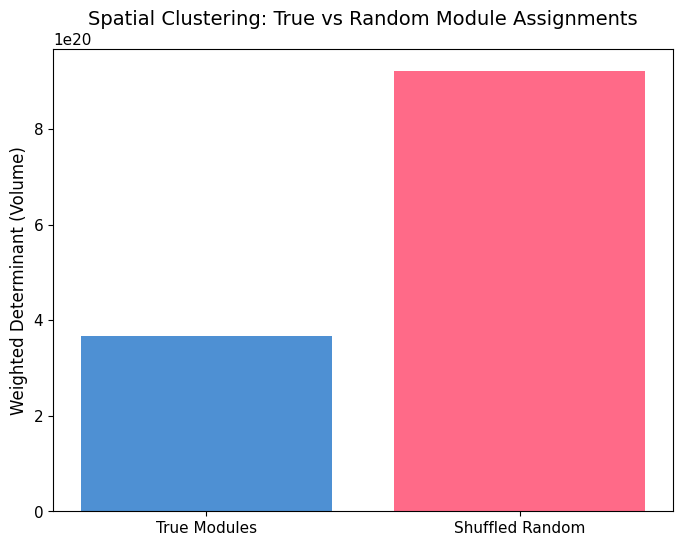

In [33]:
methods = ['True Modules', 'Shuffled Random']
volumes = [results_df['True_Volume'].mean(), results_df['Random_Volume'].mean()]

plt.figure(figsize=(8, 6))
plt.bar(methods, volumes, color=['#4e90d3', '#ff6a88'])
plt.ylabel('Weighted Determinant (Volume)', fontsize=12)
plt.title('Spatial Clustering: True vs Random Module Assignments', fontsize=14)
plt.show()

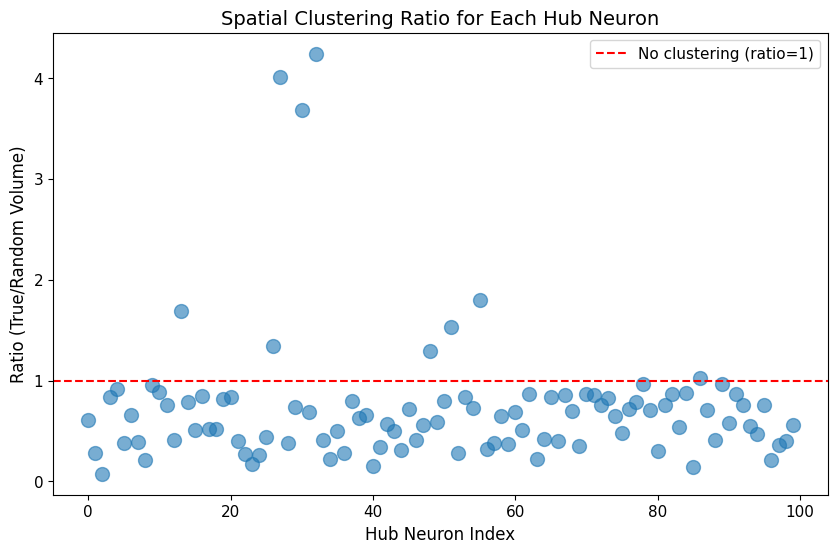

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df.index, results_df['Ratio'], s=100, alpha=0.6)
plt.axhline(y=1.0, color='red', linestyle='--', label='No clustering (ratio=1)')
plt.xlabel('Hub Neuron Index', fontsize=12)
plt.ylabel('Ratio (True/Random Volume)', fontsize=12)
plt.title('Spatial Clustering Ratio for Each Hub Neuron', fontsize=14)
plt.legend()
plt.show()

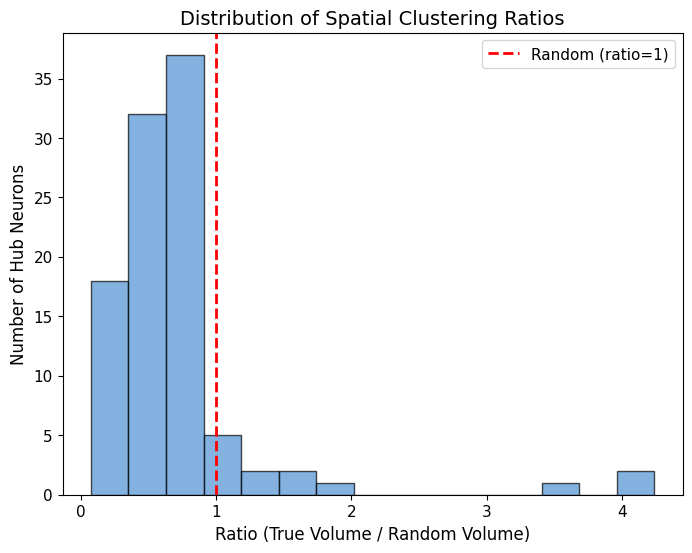

In [35]:
plt.figure(figsize=(8, 6))
plt.hist(results_df['Ratio'], bins=15, color='#4e90d3', alpha=0.7, edgecolor='black')
plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Random (ratio=1)')
plt.xlabel('Ratio (True Volume / Random Volume)', fontsize=12)
plt.ylabel('Number of Hub Neurons', fontsize=12)
plt.title('Distribution of Spatial Clustering Ratios', fontsize=14)
plt.legend()
plt.show()

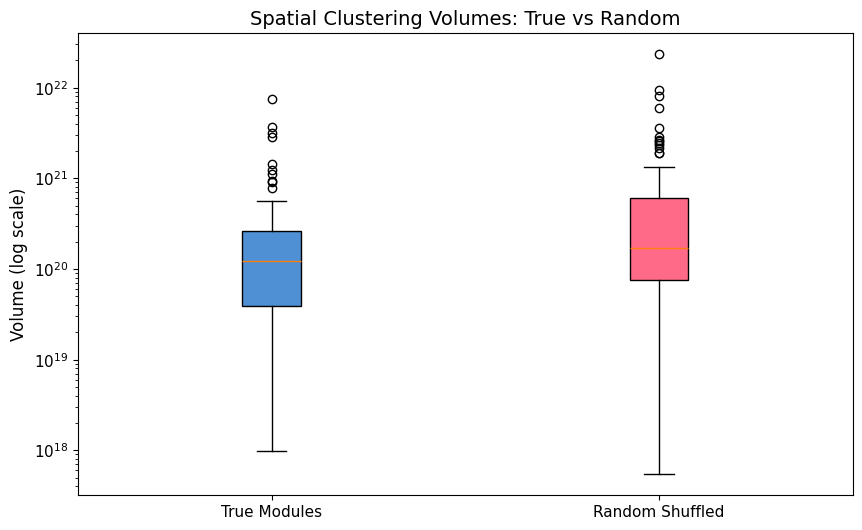

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

# Box plot
bp = ax.boxplot([results_df['True_Volume'], results_df['Random_Volume']],
                 labels=['True Modules', 'Random Shuffled'],
                 patch_artist=True)

# Color the boxes
colors = ['#4e90d3', '#ff6a88']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Volume (log scale)', fontsize=12)
ax.set_yscale('log')
ax.set_title('Spatial Clustering Volumes: True vs Random', fontsize=14)
plt.show()

In [39]:
# Extract outliers based on ratio thresholds
import numpy as np

# Define outlier threshold (ratios significantly above random baseline)
OUTLIER_THRESHOLD = 1  # Adjust this based on criteria

# Add band information to results
def assign_bands(results_df, bodyid_list, bands_config):
    """Assign each bodyId to its band"""
    band_assignments = {}

    for band in bands_config:
        for bodyid in band['sampled_bodyids']:
            band_assignments[str(bodyid)] = band['label']

    results_df['Band'] = results_df['bodyId'].map(band_assignments)
    return results_df

# Assign bands
results_df = assign_bands(results_df, high_indegree_bodyids, BANDS)

# Identify outliers
outliers_df = results_df[results_df['Ratio'] > OUTLIER_THRESHOLD].copy()
outliers_df = outliers_df.sort_values('Ratio', ascending=False)

print(f"OUTLIER NEURONS (Ratio > {OUTLIER_THRESHOLD})")
print(f"\nTotal outliers: {len(outliers_df)}/{len(results_df)}\n")

print(f"{'Body ID':<15} | {'Band':<20} | {'Ratio':<10} | {'P-Value':<10} | {'True Vol':<12} | {'Rand Vol':<12}")

for _, row in outliers_df.iterrows():
    print(f"{row['bodyId']:<15} | {row['Band']:<20} | {row['Ratio']:<10.2f} | {row['P_Value']:<10.4f} | {row['True_Volume']:<12.2e} | {row['Random_Volume']:<12.2e}")


# Statistical summary of outliers by band
print("\nOUTLIERS BY BAND:")
for band_name in outliers_df['Band'].unique():
    band_outliers = outliers_df[outliers_df['Band'] == band_name]
    total_in_band = len(results_df[results_df['Band'] == band_name])
    print(f"{band_name}: {len(band_outliers)}/{total_in_band} neurons ({100*len(band_outliers)/total_in_band:.1f}%)")

# Get bodyIds of outliers for further investigation
outlier_bodyids = outliers_df['bodyId'].astype(int).tolist()
print(f"\nOutlier body IDs: {outlier_bodyids}")

OUTLIER NEURONS (Ratio > 1)

Total outliers: 9/100

Body ID         | Band                 | Ratio      | P-Value    | True Vol     | Rand Vol    
5813020828      | Band 1 (0-10%)       | 4.24       | 1.0000     | 7.44e+18     | 1.76e+18    
5813068729      | Band 1 (0-10%)       | 4.01       | 1.0000     | 2.77e+18     | 6.90e+17    
300972942       | Band 1 (0-10%)       | 3.68       | 1.0000     | 2.66e+18     | 7.22e+17    
1139667240      | Band 2 (10-20%)      | 1.79       | 1.0000     | 9.76e+17     | 5.44e+17    
1321305370      | Band 1 (0-10%)       | 1.69       | 1.0000     | 3.74e+19     | 2.22e+19    
331662710       | Band 2 (10-20%)      | 1.53       | 1.0000     | 2.60e+20     | 1.71e+20    
733036127       | Band 1 (0-10%)       | 1.34       | 0.9990     | 1.78e+18     | 1.33e+18    
985813153       | Band 1 (0-10%)       | 1.30       | 0.9620     | 8.36e+19     | 6.45e+19    
5813019513      | Band 2 (10-20%)      | 1.03       | 0.8370     | 2.47e+19     | 2.40e+19   

BAND-SPECIFIC SUMMARIES

Band 1 (0-10%):
  Total neurons: 50
  Mean ratio: 0.789
  Median ratio: 0.565
  Neurons below baseline (ratio < 1): 44
  Neurons above baseline (ratio > 1): 6
  Significant clustering (p < 0.05): 44

Band 2 (10-20%):
  Total neurons: 50
  Mean ratio: 0.665
  Median ratio: 0.703
  Neurons below baseline (ratio < 1): 47
  Neurons above baseline (ratio > 1): 3
  Significant clustering (p < 0.05): 45


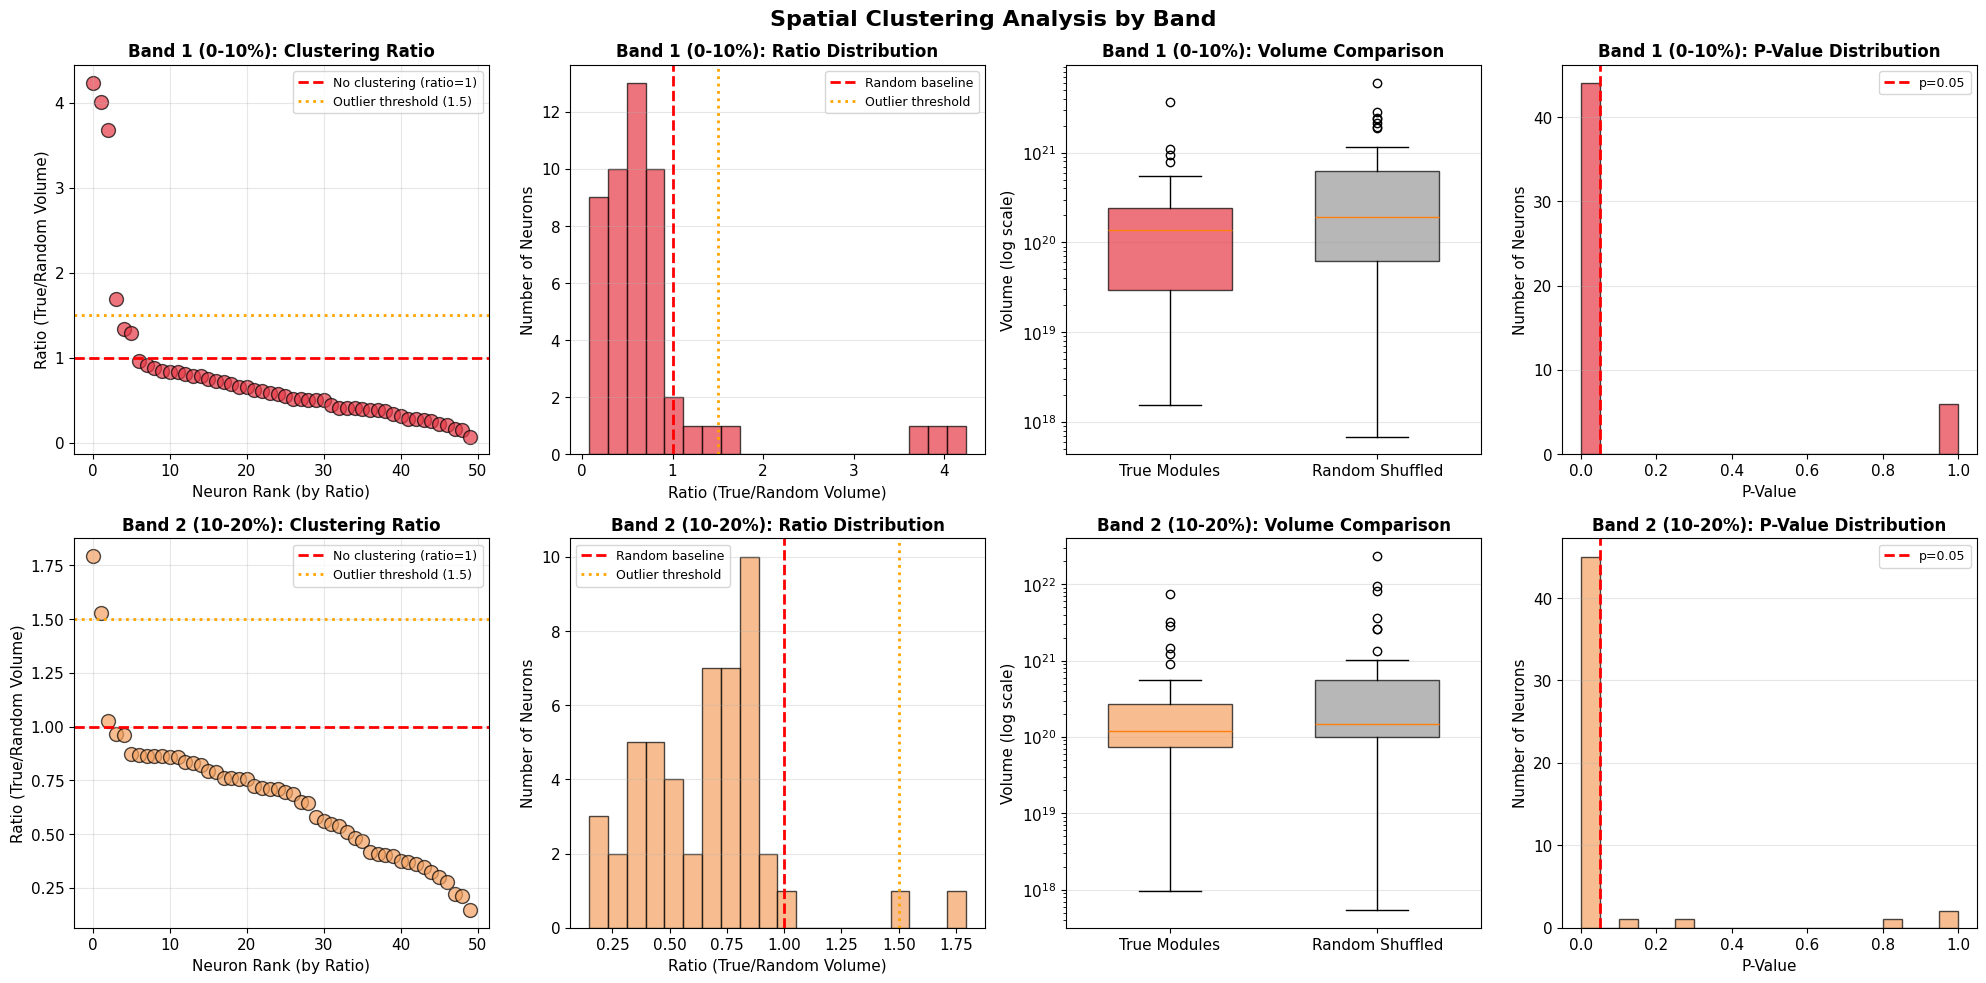

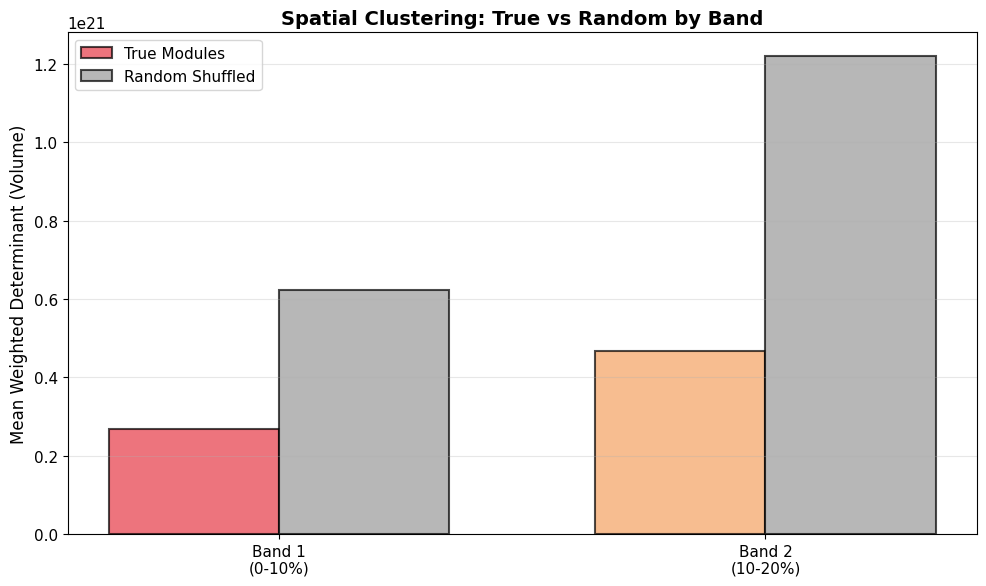

In [38]:
# Separate results by band
band1_results = results_df[results_df['Band'] == 'Band 1 (0-10%)'].copy()
band2_results = results_df[results_df['Band'] == 'Band 2 (10-20%)'].copy()

print("BAND-SPECIFIC SUMMARIES")

for band_name, band_df in [('Band 1 (0-10%)', band1_results), ('Band 2 (10-20%)', band2_results)]:
    print(f"\n{band_name}:")
    print(f"  Total neurons: {len(band_df)}")
    print(f"  Mean ratio: {band_df['Ratio'].mean():.3f}")
    print(f"  Median ratio: {band_df['Ratio'].median():.3f}")
    print(f"  Neurons below baseline (ratio < 1): {(band_df['Ratio'] < 1).sum()}")
    print(f"  Neurons above baseline (ratio > 1): {(band_df['Ratio'] > 1).sum()}")
    print(f"  Significant clustering (p < 0.05): {(band_df['P_Value'] < 0.05).sum()}")


# Create separate visualizations for each band
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Spatial Clustering Analysis by Band', fontsize=16, fontweight='bold')

band_data = [
    ('Band 1 (0-10%)', band1_results, '#E63946'),
    ('Band 2 (10-20%)', band2_results, '#F4A261')
]

for band_idx, (band_name, band_df, color) in enumerate(band_data):

    # Row for this band
    row = band_idx

    # Panel 1: Scatter plot - Ratio by neuron index
    ax1 = axes[row, 0]
    band_df_sorted = band_df.sort_values('Ratio', ascending=False).reset_index(drop=True)
    ax1.scatter(band_df_sorted.index, band_df_sorted['Ratio'], s=100, alpha=0.7,
               color=color, edgecolors='black', linewidth=1)
    ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='No clustering (ratio=1)')
    ax1.axhline(y=OUTLIER_THRESHOLD, color='orange', linestyle=':', linewidth=2, label=f'Outlier threshold ({OUTLIER_THRESHOLD})')
    ax1.set_xlabel('Neuron Rank (by Ratio)', fontsize=11)
    ax1.set_ylabel('Ratio (True/Random Volume)', fontsize=11)
    ax1.set_title(f'{band_name}: Clustering Ratio', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Panel 2: Histogram of ratios
    ax2 = axes[row, 1]
    ax2.hist(band_df['Ratio'], bins=20, color=color, alpha=0.7, edgecolor='black')
    ax2.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Random baseline')
    ax2.axvline(x=OUTLIER_THRESHOLD, color='orange', linestyle=':', linewidth=2, label='Outlier threshold')
    ax2.set_xlabel('Ratio (True/Random Volume)', fontsize=11)
    ax2.set_ylabel('Number of Neurons', fontsize=11)
    ax2.set_title(f'{band_name}: Ratio Distribution', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')

    # Panel 3: Box plot comparison
    ax3 = axes[row, 2]
    bp = ax3.boxplot([band_df['True_Volume'], band_df['Random_Volume']],
                     labels=['True Modules', 'Random Shuffled'],
                     patch_artist=True,
                     widths=0.6)

    bp['boxes'][0].set_facecolor(color)
    bp['boxes'][1].set_facecolor('#999999')

    for box in bp['boxes']:
        box.set_alpha(0.7)

    ax3.set_ylabel('Volume (log scale)', fontsize=11)
    ax3.set_yscale('log')
    ax3.set_title(f'{band_name}: Volume Comparison', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # Panel 4: P-value histogram
    ax4 = axes[row, 3]
    ax4.hist(band_df['P_Value'], bins=20, color=color, alpha=0.7, edgecolor='black')
    ax4.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='p=0.05')
    ax4.set_xlabel('P-Value', fontsize=11)
    ax4.set_ylabel('Number of Neurons', fontsize=11)
    ax4.set_title(f'{band_name}: P-Value Distribution', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# Additional: Mean volume comparison by band
fig, ax = plt.subplots(figsize=(10, 6))

band_names = ['Band 1\n(0-10%)', 'Band 2\n(10-20%)']
true_vols = [band1_results['True_Volume'].mean(), band2_results['True_Volume'].mean()]
rand_vols = [band1_results['Random_Volume'].mean(), band2_results['Random_Volume'].mean()]

x = np.arange(len(band_names))
width = 0.35

bars1 = ax.bar(x - width/2, true_vols, width, label='True Modules',
              color=['#E63946', '#F4A261'], alpha=0.7, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, rand_vols, width, label='Random Shuffled',
              color='#999999', alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Mean Weighted Determinant (Volume)', fontsize=12)
ax.set_title('Spatial Clustering: True vs Random by Band', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(band_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [40]:
from scipy import stats

print("STATISTICAL COMPARISON BETWEEN BANDS")

# T-test comparing ratios between bands
t_stat, p_value = stats.ttest_ind(band1_results['Ratio'], band2_results['Ratio'])

print(f"\nT-test: Band 1 vs Band 2 (Ratio)")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant difference: {'YES' if p_value < 0.05 else 'NO'}")

# Mann-Whitney U test (non-parametric alternative)
u_stat, u_pvalue = stats.mannwhitneyu(band1_results['Ratio'], band2_results['Ratio'])
print(f"\nMann-Whitney U test: Band 1 vs Band 2")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_pvalue:.4f}")

STATISTICAL COMPARISON BETWEEN BANDS

T-test: Band 1 vs Band 2 (Ratio)
  t-statistic: 0.9523
  p-value: 0.3433
  Significant difference: NO

Mann-Whitney U test: Band 1 vs Band 2
  U-statistic: 1110.0000
  p-value: 0.3362


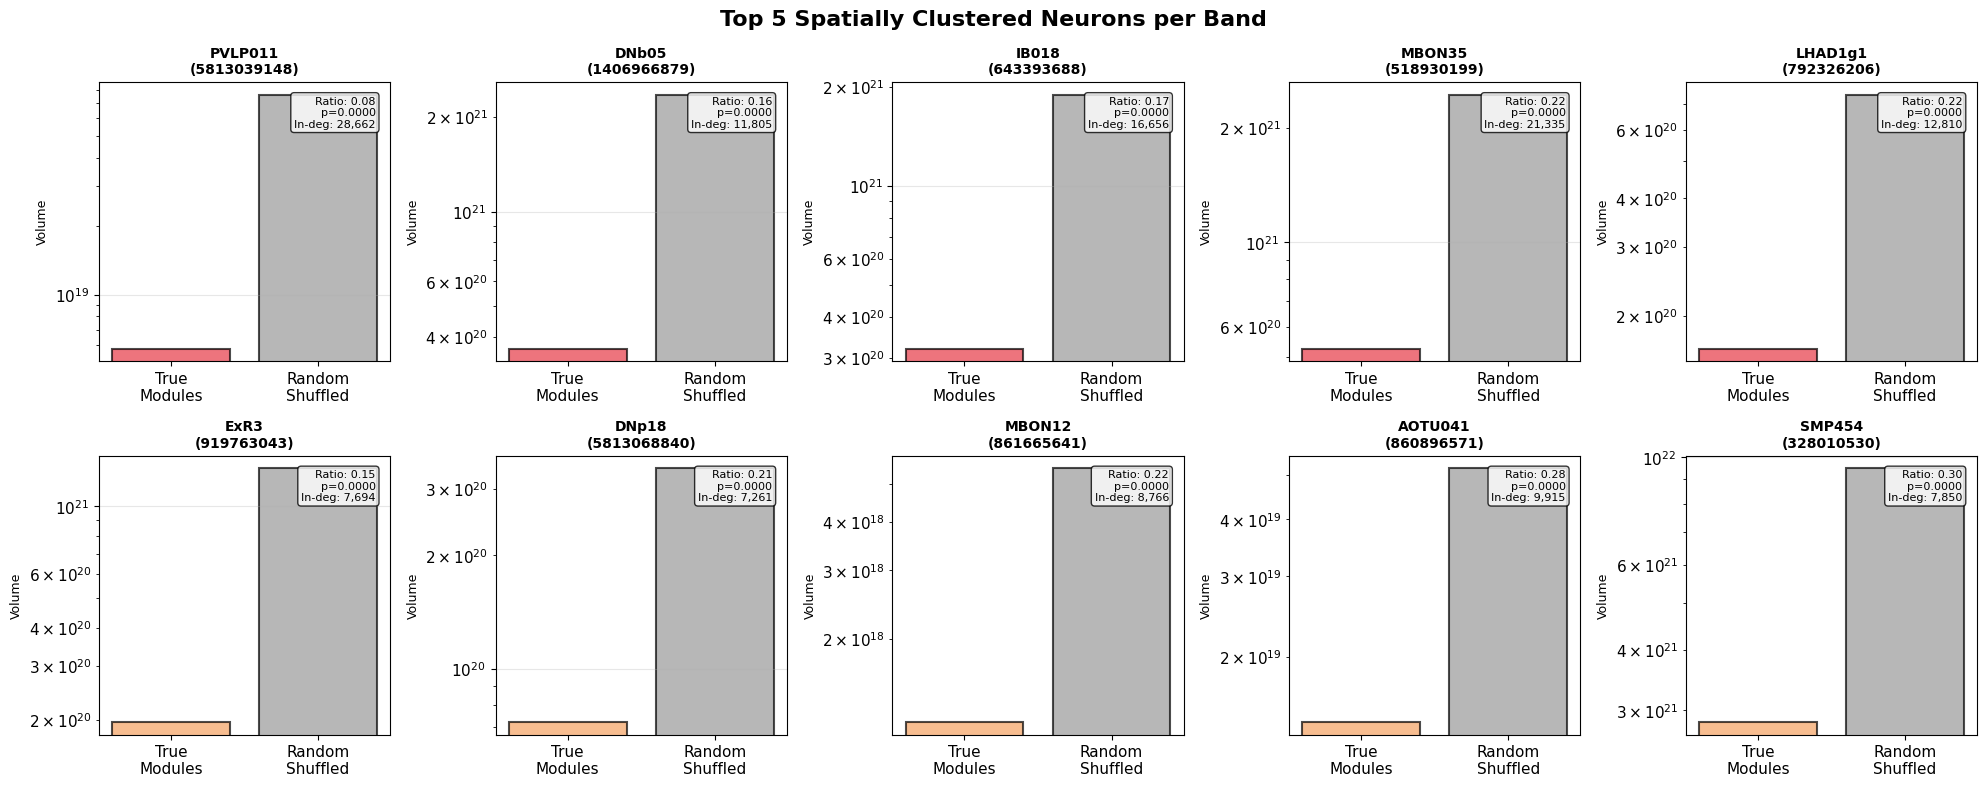

In [42]:
# Individual neuron profiles for top candidates from each band
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Top 5 Spatially Clustered Neurons per Band', fontsize=16, fontweight='bold')

for band_idx, (band_name, band_df, color) in enumerate(band_data):
    # Get top 5 most clustered (lowest ratio, significant)
    top5 = band_df[(band_df['P_Value'] < 0.05)].nsmallest(5, 'Ratio')

    for neuron_idx, (_, neuron) in enumerate(top5.iterrows()):
        ax = axes[band_idx, neuron_idx]

        bodyid = int(neuron['bodyId'])
        ratio = neuron['Ratio']
        pval = neuron['P_Value']
        true_vol = neuron['True_Volume']
        rand_vol = neuron['Random_Volume']

        # Get neuron details
        neuron_info = high_indegree_neurons[high_indegree_neurons['bodyId'] == bodyid].iloc[0]
        neuron_type = neuron_info.get('type', 'Unknown')
        indegree = neuron_info['upstream']

        # Bar chart: True vs Random
        ax.bar(['True\nModules', 'Random\nShuffled'],
              [true_vol, rand_vol],
              color=[color, '#999999'], alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_title(f'{neuron_type}\n({bodyid})', fontsize=10, fontweight='bold')
        ax.set_ylabel('Volume', fontsize=9)
        ax.set_yscale('log')

        # Add statistics text
        stats_text = f'Ratio: {ratio:.2f}\np={pval:.4f}\nIn-deg: {indegree:,}'
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
               fontsize=8, verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('top_neurons_per_band.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# Create a comprehensive decision matrix
print("DECISION MATRIX: BAND SELECTION CRITERIA")

criteria_data = []

# Calculate various metrics for comparison
for band_name, band_df in [('Band 1 (0-10%)', band1_results), ('Band 2 (10-20%)', band2_results)]:
    criteria_data.append({
        'Band': band_name,
        'Sample Size': len(band_df),
        'Clustered (%)': f"{100*(band_df['Ratio'] < 1).sum()/len(band_df):.1f}%",
        'Significant (%)': f"{100*(band_df['P_Value'] < 0.05).sum()/len(band_df):.1f}%",
        'Mean Ratio': f"{band_df['Ratio'].mean():.3f}",
        'Median Ratio': f"{band_df['Ratio'].median():.3f}",
        'Strong Cluster (%)': f"{100*((band_df['Ratio'] < 0.8) & (band_df['P_Value'] < 0.05)).sum()/len(band_df):.1f}%",
        'Mean In-Degree': f"{np.mean([high_indegree_neurons[high_indegree_neurons['bodyId'] == int(bid)]['upstream'].values[0] for bid in band_df['bodyId']]):,.0f}",
        'Outliers (>1.5)': f"{(band_df['Ratio'] > 1.5).sum()}",
    })

criteria_df = pd.DataFrame(criteria_data)
print(criteria_df.to_string(index=False))

# Interpretation guide
print("\nINTERPRETATION GUIDE:")
print("Clustered (%):        Higher = More neurons show spatial organization")
print("Significant (%):      Higher = More reliable/reproducible results")
print("Mean/Median Ratio:    Lower = Stronger overall spatial clustering")
print("Strong Cluster (%):   Higher = More neurons with robust clustering (ratio<0.8 AND p<0.05)")
print("Outliers:             Lower = More consistent patterns, less noise")

DECISION MATRIX: BAND SELECTION CRITERIA
           Band  Sample Size Clustered (%) Significant (%) Mean Ratio Median Ratio Strong Cluster (%) Mean In-Degree Outliers (>1.5)
 Band 1 (0-10%)           50         88.0%           88.0%      0.789        0.565              74.0%         18,531               4
Band 2 (10-20%)           50         94.0%           90.0%      0.665        0.703              70.0%          8,370               2

INTERPRETATION GUIDE:
Clustered (%):        Higher = More neurons show spatial organization
Significant (%):      Higher = More reliable/reproducible results
Mean/Median Ratio:    Lower = Stronger overall spatial clustering
Strong Cluster (%):   Higher = More neurons with robust clustering (ratio<0.8 AND p<0.05)
Outliers:             Lower = More consistent patterns, less noise
